In [46]:
import pandas as pd
from dotenv import load_dotenv
import os
import google.generativeai as genai
import time
load_dotenv()
from keylog_analysis_helper import *
from data_prep_helper import *
from gemini_prompts import *
import difflib

import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import time

Notes
- Code reconstruction may be incorrect, double check again
- Measures of progress:
    - Whether code compiles,
    - Ask llm if it progressed?
    - '# characters written
        - Those that are code and not (ask llm)


- does this portion make sense
- does this portion make sense to the solution 


Define model

In [28]:
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

# Create the model
generation_config = {
  "temperature": 0,
  "top_p": 0.95,
  "top_k": 1,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-pro-002",
  generation_config=generation_config,
  system_instruction= system_instructions,
)

# chat_session = model.start_chat(
#   history=[
#   ]
# )

In [29]:
# Read assignment instructions
instructions_a3 = read_file_as_string("archive/CompleteAssignments/a3_P0_c0/Project3.txt")
instructions_a4 = read_file_as_string("archive/CompleteAssignments/a4_P0_c0/Project4.txt")

# Initialize a differ object
differ = difflib.Differ()


In [30]:
# Define system prompt
def form_system_prompt():
    return f"""
    You are an assistant who evaluates whether students are making meaningful progress toward passing more test cases in their coding assignments.
    Your task is to analyze snapshots of their code and predict:
    1. Whether the student made progress in passing more test cases in the last {n} minutes.
    2. Whether the student is on track to pass more test cases in the next {n} minutes.
    
    Your response must be strictly two numbers separated by a hyphen, in the format: X-Y
    - X (first value): 1 if progress was made in the last {n} minutes, 0 if no meaningful progress was made.
    - Y (second value): 1 if the student is on track to pass more test cases in the next {n} minutes, 0 if they are not.

    Be critical in your evaluation:
    - Only predict 1 if there is clear evidence of meaningful progress (e.g., implementing or fixing logic relevant to passing test cases).
    - Predict 0 if the changes are superficial, irrelevant, or show no improvement toward the assignment goals.

    Do not provide any comments, explanations, or descriptions. Return only the two numbers separated by a hyphen (e.g., 1-1 or 0-0).
    """

# Define context
def form_context(file1_name, file1_prev, file1_current, file1_diff, 
                 file2_name, file2_prev, file2_current, file2_diff, instructions):
    return f"""
    Evaluate the student's progress based on the following snapshots and diffs. Provide your prediction in the format X-Y:
    - X: Whether the student made progress in passing more test cases in the last {n} minutes.
    - Y: Whether the student is on track to pass more test cases in the next {n} minutes.

    Assignment Instructions:
    {instructions}

    Snapshot and diff details:
    - File 1 ({file1_name}):
      - Previous Snapshot: {file1_prev}
      - Current Snapshot: {file1_current}
      - Diff: {file1_diff}

    - File 2 ({file2_name}):
      - Previous Snapshot: {file2_prev}
      - Current Snapshot: {file2_current}
      - Diff: {file2_diff}
    """

# Define prompt with conditions
def form_prompt(file1_name, file1_prev, file1_current, file1_diff, 
                file2_name, file2_prev, file2_current, file2_diff, instructions):
    file1_message = "No changes were made to the file." if not any(file1_diff) else f"""
    Previous Version of {file1_name}:
    {file1_prev}

    Diff for {file1_name}:
    {file1_diff}
    """
    file2_message = "No changes were made to the file." if not any(file2_diff) else f"""
    Previous Version of {file2_name}:
    {file2_prev}

    Diff for {file2_name}:
    {file2_diff}
    """
    return f"""
    Analyze the following data to evaluate student progress. Provide your response in the format X-Y, where:
    - X: 1 if the student made progress in passing more test cases in the last {n} minutes, otherwise 0.
    - Y: 1 if the student is on track to pass more test cases in the next {n} minutes, otherwise 0.

    Be critical in your analysis and only predict 1 if there is clear evidence of meaningful progress or alignment with the assignment goals.

    {file1_message}

    {file2_message}

    Assignment Instructions:
    {instructions}

    IMPORTANT: Your response must only contain the two numbers separated by a hyphen (e.g., 1-1 or 0-0). Do not include any extra comments or descriptions.
    """


Main Function

In [ ]:
# Integration with dataframe and LLM response handling
def make_llm_comparisons(a3=True):
    # Read df based on assignment type
    if a3:
        df = pd.read_csv("KeylogDatasets/a3.csv")
    else:
        df = pd.read_csv("KeylogDatasets/a4.csv")
   
    df["Prediction_0"] = None  # Prediction for progress in the last n minutes
    df["Prediction_1"] = None  # Prediction for progress in the next n minutes

    p_list = p_list_a3_log_analysis if a3 else p_list_a4_log_analysis
    assignment = 'a3' if a3 else 'a4'
    snapshots_dir = snapshots_dir_a3 if a3 else snapshots_dir_a4

    total_token = 0
    for p in p_list[:-1]:
        print("--Now working on participant", p)
        df_temp = df[df["participant"] == p]

        for idx, row in df_temp.iterrows():
            if row['snapshot'] == 0:
                continue

            current_snapshot = row['snapshot']
            prev_snapshot = row['snapshot'] - 1
            print("Now comparing snapshots", prev_snapshot, current_snapshot)
            
            # Read files
            if a3:
                prev_snapshot_dir = os.path.join(snapshots_dir, f'{assignment}_{p}_c{prev_snapshot}', "tracking")
                current_snapshot_dir = os.path.join(snapshots_dir, f'{assignment}_{p}_c{current_snapshot}', "tracking")
                file1_prev = read_file_as_string(os.path.join(prev_snapshot_dir, "bustersAgents.py"))
                file1_current = read_file_as_string(os.path.join(current_snapshot_dir, "bustersAgents.py"))
                file2_prev = read_file_as_string(os.path.join(prev_snapshot_dir, "inference.py"))
                file2_current = read_file_as_string(os.path.join(current_snapshot_dir, "inference.py"))
                instructions = instructions_a3
            else:
                prev_snapshot_dir = os.path.join(snapshots_dir, f'{assignment}_{p}_c{prev_snapshot}')
                current_snapshot_dir = os.path.join(snapshots_dir, f'{assignment}_{p}_c{current_snapshot}')
                file1_prev = read_file_as_string(os.path.join(prev_snapshot_dir, "NeuralNet.py"))
                file1_current = read_file_as_string(os.path.join(current_snapshot_dir, "NeuralNet.py"))
                file2_prev = read_file_as_string(os.path.join(prev_snapshot_dir, "NeuralNetUtil.py"))
                file2_current = read_file_as_string(os.path.join(current_snapshot_dir, "NeuralNetUtil.py"))
                instructions = instructions_a4

            # Run diff
            file1_diff = list(difflib.Differ().compare(file1_prev.splitlines(), file1_current.splitlines()))
            file2_diff = list(difflib.Differ().compare(file2_prev.splitlines(), file2_current.splitlines()))

            # Ask the LLM
            prompt = form_prompt("bustersAgents.py", file1_prev, file1_current, file1_diff, 
                                 "inference.py", file2_prev, file2_current, file2_diff, instructions)

            print(f"Prompt length: {len(prompt)}")
            try:
                response = model.generate_content(prompt)
                total_token += response.usage_metadata.total_token_count
                response_text = response.parts[0].text.strip()
                print(f"LLM Response: {response_text}")

                if "-" in response_text:
                    prediction_1, prediction_2 = map(int, response_text.split("-"))
                    df.at[idx, "Prediction_1"] = prediction_1
                    df.at[idx, "Prediction_2"] = prediction_2
                else:
                    print("Invalid response format. Skipping this row.")
            except Exception as e:
                print("Error generating response: ", e)
                continue

        print("Total tokens used so far: ", total_token)
    
    return df

In [35]:
n = 5

In [36]:
df_a3 = make_llm_comparisons(a3=True)

--Now working on participant P3
Now comparing snapshots 0 1
Prompt length: 78066
LLM Response: 0-0
Now comparing snapshots 1 2
Prompt length: 78112
LLM Response: 0-1
Now comparing snapshots 2 3
Prompt length: 78411
LLM Response: 0-0
Now comparing snapshots 3 4
Prompt length: 78851
LLM Response: 0-1
Now comparing snapshots 4 5
Prompt length: 79401
LLM Response: 0-1
Now comparing snapshots 5 6
Prompt length: 79436
LLM Response: 0-1
Now comparing snapshots 6 7
Prompt length: 79205
LLM Response: 0-0
Now comparing snapshots 7 8
Prompt length: 79346
LLM Response: 0-1
Now comparing snapshots 8 9
Prompt length: 79587
LLM Response: 0-0
Now comparing snapshots 9 10
Prompt length: 79918
LLM Response: 0-1
Now comparing snapshots 10 11
Prompt length: 79756
LLM Response: 0-0
Now comparing snapshots 11 12
Prompt length: 80005
LLM Response: 1-1
Now comparing snapshots 12 13
Prompt length: 80064
LLM Response: 0-1
Now comparing snapshots 13 14
Prompt length: 80092
LLM Response: 1-1
Total tokens used so 

In [37]:
df_a4 = make_llm_comparisons(a3=False)

--Now working on participant P9
Now comparing snapshots 0 1
Prompt length: 53750
LLM Response: 0-0
Now comparing snapshots 1 2
Prompt length: 53902
LLM Response: 0-0
Now comparing snapshots 2 3
Prompt length: 54140
LLM Response: 0-0
Now comparing snapshots 3 4
Prompt length: 54247
LLM Response: 0-0
Now comparing snapshots 4 5
Prompt length: 54247
LLM Response: 0-0
Now comparing snapshots 5 6
Prompt length: 54290
LLM Response: 0-0
Now comparing snapshots 6 7
Prompt length: 54518
LLM Response: 0-0
Now comparing snapshots 7 8
Prompt length: 54716
LLM Response: 0-0
Now comparing snapshots 9 10
Prompt length: 54905
LLM Response: 0-0
Now comparing snapshots 10 11
Prompt length: 54957
LLM Response: 0-0
Now comparing snapshots 11 12
Prompt length: 54999
LLM Response: 0-0
Now comparing snapshots 12 13
Prompt length: 55281
LLM Response: 0-0
Now comparing snapshots 13 14
Prompt length: 55367
LLM Response: 0-0
Now comparing snapshots 14 15
Prompt length: 55495
LLM Response: 0-1
Now comparing snaps

In [38]:
df_a3.to_csv("KeylogDatasets/a3_predictions.csv", index=False)
df_a4.to_csv("KeylogDatasets/a4_predictions.csv", index=False)

In [44]:
df_a3 = pd.read_csv("KeylogDatasets/a3_predictions.csv")
df_a4 = pd.read_csv("KeylogDatasets/a4_predictions.csv")

In [45]:
df_a3

,Unnamed: 0,participant,snapshot,bustersAgents.py_compiles,inference.py_compiles,bustersAgents.py_length,inference.py_length,q1_points,q5_points,q6_points,q4_points,q2_points,q7_points,q3_points,total_points,Prediction_0,Prediction_1
0,0,P11,0,1,1,6891,19913,0,0,0,0,0,0,0,0.0,NaN,NaN
1,1,P11,1,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2,P11,2,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0
3,3,P11,3,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0
4,4,P11,4,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,417,P9,11,1,1,6922,20998,0,0,0,0,0,0,0,0.0,0.0,0.0
418,418,P9,12,1,1,6922,21107,0,0,0,0,0,0,0,0.0,0.0,0.0
419,419,P9,13,1,1,6922,21379,0,0,0,0,0,0,0,0.0,0.0,0.0
420,420,P9,14,1,1,6922,21378,3,0,0,0,0,0,0,3.0,0.0,0.0


Compute metrics

In [48]:
def compute_ground_truths(df):
    df = df.sort_values(by=['participant', 'snapshot']).reset_index(drop=True)

    # Compute GroundTruth_1 and GroundTruth_2
    df['GroundTruth_1'] = np.nan 
    df['GroundTruth_2'] = np.nan  

    participants = df['participant'].unique()

    for participant in participants:
        participant_df = df[df['participant'] == participant]
        indices = participant_df.index

        # Compute GroundTruth_1 : whether the student made progress in passing more test cases in the last n minutes
        for i in indices[1:]:  # Skip the first snapshot
            current_total = df.loc[i, 'total_points']
            previous_total = df.loc[i - 1, 'total_points']
            if df.loc[i - 1, 'participant'] == participant:
                df.loc[i, 'GroundTruth_1'] = int(current_total > previous_total)

        # Compute GroundTruth_2 : whether the student is on track to pass more test cases in the next n minutes
        for i in indices[:-1]:  # Skip the last snapshot
            current_total = df.loc[i, 'total_points']
            next_total = df.loc[i + 1, 'total_points']
            if df.loc[i + 1, 'participant'] == participant:
                df.loc[i, 'GroundTruth_2'] = int(next_total > current_total)

    return df

In [49]:
df_a3 = compute_ground_truths(df_a3)
df_a4 = compute_ground_truths(df_a4)

In [109]:
df_a3

,Unnamed: 0,participant,snapshot,bustersAgents.py_compiles,inference.py_compiles,bustersAgents.py_length,inference.py_length,q1_points,q5_points,q6_points,q4_points,q2_points,q7_points,q3_points,total_points,Prediction_1,Prediction_2,GroundTruth_1,GroundTruth_2
0,0,P11,0,1,1,6891,19913,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,0.0
1,1,P11,1,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2,P11,2,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,3,P11,3,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,4,P11,4,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,417,P9,11,1,1,6922,20998,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
418,418,P9,12,1,1,6922,21107,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
419,419,P9,13,1,1,6922,21379,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
420,420,P9,14,1,1,6922,21378,3,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0


Compute metrics

In [78]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(df):        
    # Initialize dictionaries to store scores
    accuracy_scores = {'Prediction_1': {}, 'Prediction_2': {}}
    f1_scores = {'Prediction_1': {}, 'Prediction_2': {}}

    # We'll also collect overall predictions and ground truths
    overall_preds_0 = []
    overall_truths_0 = []
    overall_preds_1 = []
    overall_truths_1 = []

    participants = df['participant'].unique()

    for participant in participants:
        participant_df = df[df['participant'] == participant]

        # For Prediction_0 and GroundTruth_1
        valid_df_0 = participant_df[['Prediction_1', 'GroundTruth_1']].dropna()
        preds_0 = valid_df_0['Prediction_1'].astype(float)
        truths_0 = valid_df_0['GroundTruth_1'].astype(float)

        # For Prediction_1 and GroundTruth_2
        valid_df_1 = participant_df[['Prediction_2', 'GroundTruth_2']].dropna()
        preds_1 = valid_df_1['Prediction_2'].astype(float)
        truths_1 = valid_df_1['GroundTruth_2'].astype(float)

        # Store overall predictions and truths
        overall_preds_0.extend(preds_0)
        overall_truths_0.extend(truths_0)
        overall_preds_1.extend(preds_1)
        overall_truths_1.extend(truths_1)

        # Compute accuracy and F1 scores for Prediction_1
        if len(truths_0) > 0:
            acc_0 = accuracy_score(truths_0, preds_0)
            f1_0 = f1_score(truths_0, preds_0, average='macro', zero_division=1)
            accuracy_scores['Prediction_1'][participant] = round(acc_0,2)
            f1_scores['Prediction_1'][participant] = round(f1_0,2)
        else:
            accuracy_scores['Prediction_1'][participant] = np.nan
            f1_scores['Prediction_1'][participant] = np.nan

        # Compute accuracy and F1 scores for Prediction_2
        if len(truths_1) > 0:
            acc_1 = accuracy_score(truths_1, preds_1)
            f1_1 = f1_score(truths_1, preds_1, average='macro', zero_division=1)
            accuracy_scores['Prediction_2'][participant] = round(acc_1,2)
            f1_scores['Prediction_2'][participant] = round(f1_1,2)
        else:
            accuracy_scores['Prediction_2'][participant] = np.nan
            f1_scores['Prediction_2'][participant] = np.nan

    # Compute overall accuracy and F1 scores
    overall_accuracy_0 = round(accuracy_score(overall_truths_0, overall_preds_0),2)
    overall_f1_0 = round(f1_score(overall_truths_0, overall_preds_0, average='macro', zero_division=1),2)

    overall_accuracy_1 = round(accuracy_score(overall_truths_1, overall_preds_1),2)
    overall_f1_1 = round(f1_score(overall_truths_1, overall_preds_1, average='macro', zero_division=1),2)

    return accuracy_scores, f1_scores, overall_accuracy_0, overall_f1_0, overall_accuracy_1, overall_f1_1

In [62]:
metrics_a3 = compute_metrics(df_a3)
metrics_a3

({'Prediction_0': {'P11': 0.84,
   'P12': 0.95,
   'P13': 0.91,
   'P19': 0.43,
   'P20': 0.9,
   'P21': 0.95,
   'P24': 1.0,
   'P28': 1.0,
   'P29': 0.81,
   'P3': 0.86,
   'P30': 0.95,
   'P34': 1.0,
   'P42': 0.81,
   'P43': 0.92,
   'P47': nan,
   'P5': 0.51,
   'P8': 0.94,
   'P9': 0.93},
  'Prediction_1': {'P11': 0.67,
   'P12': 0.79,
   'P13': 0.67,
   'P19': 0.36,
   'P20': 0.7,
   'P21': 0.75,
   'P24': 0.76,
   'P28': 0.85,
   'P29': 0.42,
   'P3': 0.38,
   'P30': 0.68,
   'P34': 0.8,
   'P42': 0.65,
   'P43': 0.74,
   'P47': nan,
   'P5': 0.25,
   'P8': 0.71,
   'P9': 0.85}},
 {'Prediction_0': {'P11': 0.7,
   'P12': 0.49,
   'P13': 0.72,
   'P19': 0.3,
   'P20': 0.72,
   'P21': 0.49,
   'P24': 1.0,
   'P28': 1.0,
   'P29': 0.45,
   'P3': 0.46,
   'P30': 0.82,
   'P34': 1.0,
   'P42': 0.45,
   'P43': 0.48,
   'P47': nan,
   'P5': 0.34,
   'P8': 0.49,
   'P9': 0.48},
  'Prediction_1': {'P11': 0.49,
   'P12': 0.44,
   'P13': 0.51,
   'P19': 0.31,
   'P20': 0.53,
   'P21': 0.43

In [63]:
metrics_a4 = compute_metrics(df_a4)
metrics_a4

({'Prediction_0': {'P11': 0.59,
   'P15': 0.3,
   'P16': 0.8,
   'P19': 0.16,
   'P20': 0.8,
   'P29': 0.25,
   'P30': 0.24,
   'P34': 0.69,
   'P36': 0.63,
   'P42': 0.55,
   'P43': 0.44,
   'P50': 0.32,
   'P52': 0.25,
   'P53': nan,
   'P9': 1.0},
  'Prediction_1': {'P11': 0.75,
   'P15': 0.74,
   'P16': 1.0,
   'P19': 0.56,
   'P20': 1.0,
   'P29': 0.58,
   'P30': 0.9,
   'P34': 0.92,
   'P36': 0.83,
   'P42': 0.89,
   'P43': 0.92,
   'P50': 0.81,
   'P52': 0.58,
   'P53': nan,
   'P9': 0.95}},
 {'Prediction_0': {'P11': 0.53,
   'P15': 0.27,
   'P16': 0.44,
   'P19': 0.14,
   'P20': 0.44,
   'P29': 0.25,
   'P30': 0.22,
   'P34': 0.41,
   'P36': 0.39,
   'P42': 0.35,
   'P43': 0.31,
   'P50': 0.3,
   'P52': 0.25,
   'P53': nan,
   'P9': 1.0},
  'Prediction_1': {'P11': 0.59,
   'P15': 0.42,
   'P16': 1.0,
   'P19': 0.36,
   'P20': 1.0,
   'P29': 0.51,
   'P30': 0.72,
   'P34': 0.48,
   'P36': 0.45,
   'P42': 0.47,
   'P43': 0.48,
   'P50': 0.67,
   'P52': 0.51,
   'P53': nan,
   'P9

In [79]:
def present_results(df):
    # Print per participant scores
    participants = df['participant'].unique()
    accuracy_scores, f1_scores, overall_accuracy_0, overall_f1_0, overall_accuracy_1, overall_f1_1 = compute_metrics(df)
    print("Per Participant Accuracy and F1 Scores for Prediction_1 (GroundTruth_1):")
    for participant in participants:
        acc = accuracy_scores['Prediction_1'][participant]
        f1 = f1_scores['Prediction_1'][participant]
        print(f"Participant {participant}: Accuracy = {acc:.2f}, F1 Score = {f1:.2f}")

    print("\nPer Participant Accuracy and F1 Scores for Prediction_2 (GroundTruth_2):")
    for participant in participants:
        acc = accuracy_scores['Prediction_2'][participant]
        f1 = f1_scores['Prediction_2'][participant]
        print(f"Participant {participant}: Accuracy = {acc:.2f}, F1 Score = {f1:.2f}")

    # Print overall scores
    print("\nOverall Accuracy and F1 Scores:")
    print(f"Prediction_1 (GroundTruth_1): Accuracy = {overall_accuracy_0:.2f}, F1 Score = {overall_f1_0:.2f}")
    print(f"Prediction_2 (GroundTruth_2): Accuracy = {overall_accuracy_1:.2f}, F1 Score = {overall_f1_1:.2f}")

In [80]:
present_results(df_a3)

Per Participant Accuracy and F1 Scores for Prediction_1 (GroundTruth_1):
Participant P11: Accuracy = 0.84, F1 Score = 0.70
Participant P12: Accuracy = 0.95, F1 Score = 0.49
Participant P13: Accuracy = 0.91, F1 Score = 0.72
Participant P19: Accuracy = 0.43, F1 Score = 0.30
Participant P20: Accuracy = 0.90, F1 Score = 0.72
Participant P21: Accuracy = 0.95, F1 Score = 0.49
Participant P24: Accuracy = 1.00, F1 Score = 1.00
Participant P28: Accuracy = 1.00, F1 Score = 1.00
Participant P29: Accuracy = 0.81, F1 Score = 0.45
Participant P3: Accuracy = 0.86, F1 Score = 0.46
Participant P30: Accuracy = 0.95, F1 Score = 0.82
Participant P34: Accuracy = 1.00, F1 Score = 1.00
Participant P42: Accuracy = 0.81, F1 Score = 0.45
Participant P43: Accuracy = 0.92, F1 Score = 0.48
Participant P47: Accuracy = nan, F1 Score = nan
Participant P5: Accuracy = 0.51, F1 Score = 0.34
Participant P8: Accuracy = 0.94, F1 Score = 0.49
Participant P9: Accuracy = 0.93, F1 Score = 0.48

Per Participant Accuracy and F1 

In [81]:
present_results(df_a4)

Per Participant Accuracy and F1 Scores for Prediction_1 (GroundTruth_1):
Participant P11: Accuracy = 0.59, F1 Score = 0.53
Participant P15: Accuracy = 0.30, F1 Score = 0.27
Participant P16: Accuracy = 0.80, F1 Score = 0.44
Participant P19: Accuracy = 0.16, F1 Score = 0.14
Participant P20: Accuracy = 0.80, F1 Score = 0.44
Participant P29: Accuracy = 0.25, F1 Score = 0.25
Participant P30: Accuracy = 0.24, F1 Score = 0.22
Participant P34: Accuracy = 0.69, F1 Score = 0.41
Participant P36: Accuracy = 0.63, F1 Score = 0.39
Participant P42: Accuracy = 0.55, F1 Score = 0.35
Participant P43: Accuracy = 0.44, F1 Score = 0.31
Participant P50: Accuracy = 0.32, F1 Score = 0.30
Participant P52: Accuracy = 0.25, F1 Score = 0.25
Participant P53: Accuracy = nan, F1 Score = nan
Participant P9: Accuracy = 1.00, F1 Score = 1.00

Per Participant Accuracy and F1 Scores for Prediction_2 (GroundTruth_2):
Participant P11: Accuracy = 0.75, F1 Score = 0.59
Participant P15: Accuracy = 0.74, F1 Score = 0.42
Partic

In [82]:
df_a3

,Unnamed: 0,participant,snapshot,bustersAgents.py_compiles,inference.py_compiles,bustersAgents.py_length,inference.py_length,q1_points,q5_points,q6_points,q4_points,q2_points,q7_points,q3_points,total_points,Prediction_1,Prediction_2,GroundTruth_1,GroundTruth_2
0,0,P11,0,1,1,6891,19913,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,0.0
1,1,P11,1,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2,P11,2,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,3,P11,3,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,4,P11,4,1,1,6891,19913,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,417,P9,11,1,1,6922,20998,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
418,418,P9,12,1,1,6922,21107,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
419,419,P9,13,1,1,6922,21379,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
420,420,P9,14,1,1,6922,21378,3,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0


In [113]:
def plot_predictions(df):
    participants = df['participant'].unique()
    
    accuracy_scores, f1_scores, overall_accuracy_0, overall_f1_0, overall_accuracy_1, overall_f1_1 = compute_metrics(df)
    for participant in participants:
        # Filter data for the participant
        participant_df = df[df['participant'] == participant].dropna()
        # plot file_1

        fig, axes = plt.subplots(1,2,figsize=(14, 6))

        # Plot 1: File lengths over snapshots
        sns.lineplot(
            data=participant_df,
            x='snapshot',
            y="Prediction_1",
            label="Prediction_1",
            ax=axes[0]
        )
        sns.lineplot(
            data=participant_df,
            x='snapshot',
            y="GroundTruth_1",
            label="GroundTruth_1",
            ax=axes[0]
        )
        sns.lineplot(
            data=participant_df,
            x='snapshot',
            y="Prediction_2",
            label="Prediction_2",
            ax=axes[1]
        )
        sns.lineplot(
            data=participant_df,
            x='snapshot',
            y="GroundTruth_2",
            label="GroundTruth_2",
            ax=axes[1]
        )

        axes[0].set_xlabel('Snapshot Number')
        axes[0].set_ylabel('Previous progress')
        axes[0].legend(loc='upper left')
        axes[1].set_xlabel('Snapshot Number')
        axes[1].set_ylabel('Future progress')
        axes[1].legend(loc='upper left')

        plt.suptitle(f'LLM Predictions vs ground truth')
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Add space for the main title
        plt.title(f'Participant {participant}')
        
        # Show the plots
        plt.show()

        # print metrics
        print(f"Participant {participant}:")
        print(f"Prediction_1: Accuracy = {accuracy_scores['Prediction_1'][participant]}, F1 Score = {f1_scores['Prediction_1'][participant]}")
        print(f"Prediction_2: Accuracy = {accuracy_scores['Prediction_2'][participant]}, F1 Score = {f1_scores['Prediction_2'][participant]}")
        # print value counts for each class of ground truth
        print(participant_df['GroundTruth_1'].value_counts())
        print(participant_df['GroundTruth_2'].value_counts())

    

In [114]:
df_a3.columns

Index(['Unnamed: 0', 'participant', 'snapshot', 'bustersAgents.py_compiles',
       'inference.py_compiles', 'bustersAgents.py_length',
       'inference.py_length', 'q1_points', 'q5_points', 'q6_points',
       'q4_points', 'q2_points', 'q7_points', 'q3_points', 'total_points',
       'Prediction_1', 'Prediction_2', 'GroundTruth_1', 'GroundTruth_2'],
      dtype='object')

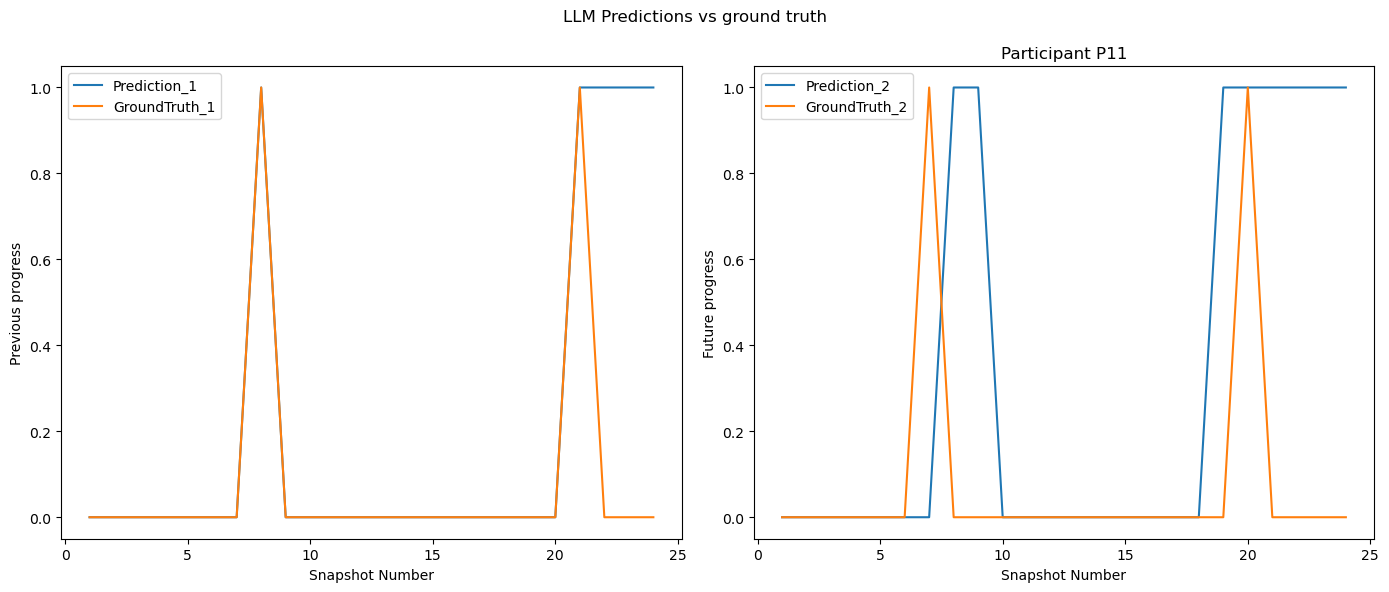

Participant P11:
Prediction_1: Accuracy = 0.84, F1 Score = 0.7
Prediction_2: Accuracy = 0.67, F1 Score = 0.49
GroundTruth_1
0.0    22
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    22
1.0     2
Name: count, dtype: int64


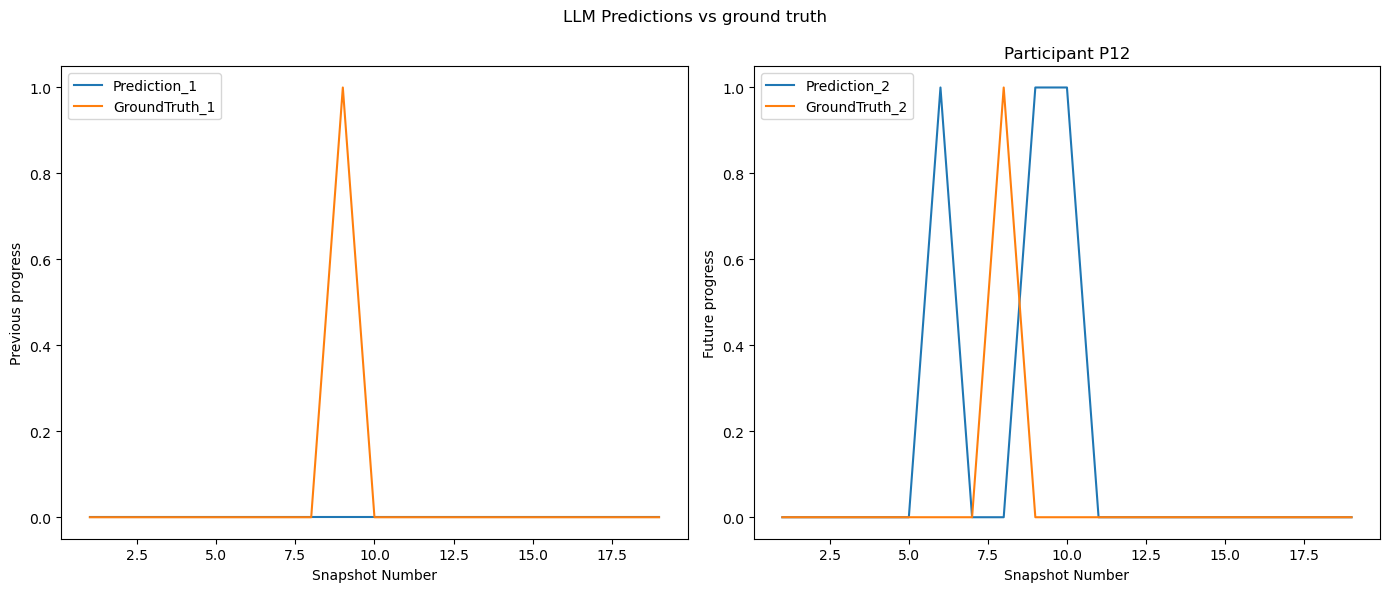

Participant P12:
Prediction_1: Accuracy = 0.95, F1 Score = 0.49
Prediction_2: Accuracy = 0.79, F1 Score = 0.44
GroundTruth_1
0.0    18
1.0     1
Name: count, dtype: int64
GroundTruth_2
0.0    18
1.0     1
Name: count, dtype: int64


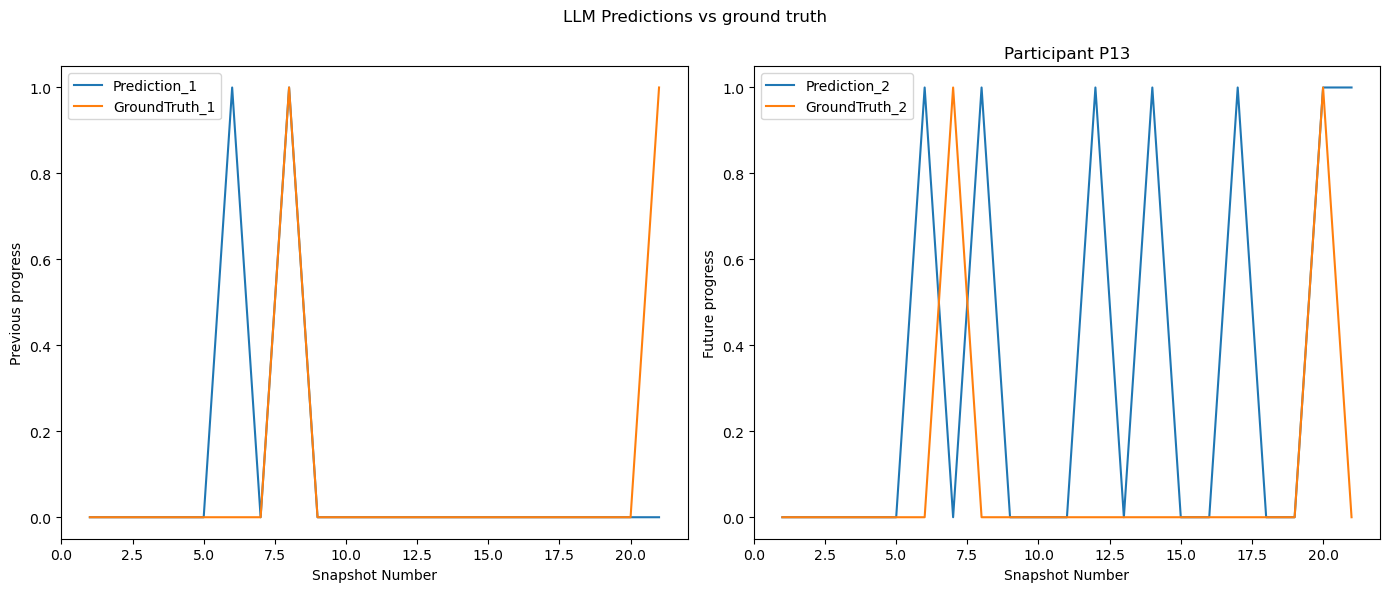

Participant P13:
Prediction_1: Accuracy = 0.91, F1 Score = 0.72
Prediction_2: Accuracy = 0.67, F1 Score = 0.51
GroundTruth_1
0.0    19
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    19
1.0     2
Name: count, dtype: int64


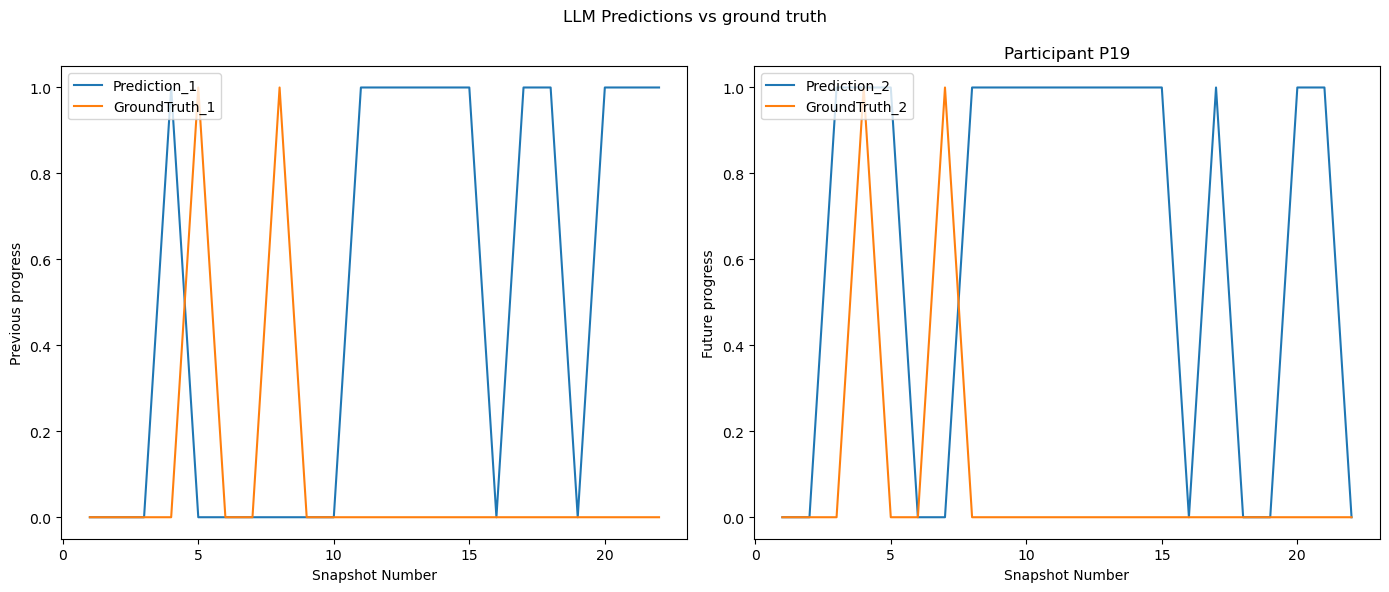

Participant P19:
Prediction_1: Accuracy = 0.43, F1 Score = 0.3
Prediction_2: Accuracy = 0.36, F1 Score = 0.31
GroundTruth_1
0.0    20
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    20
1.0     2
Name: count, dtype: int64


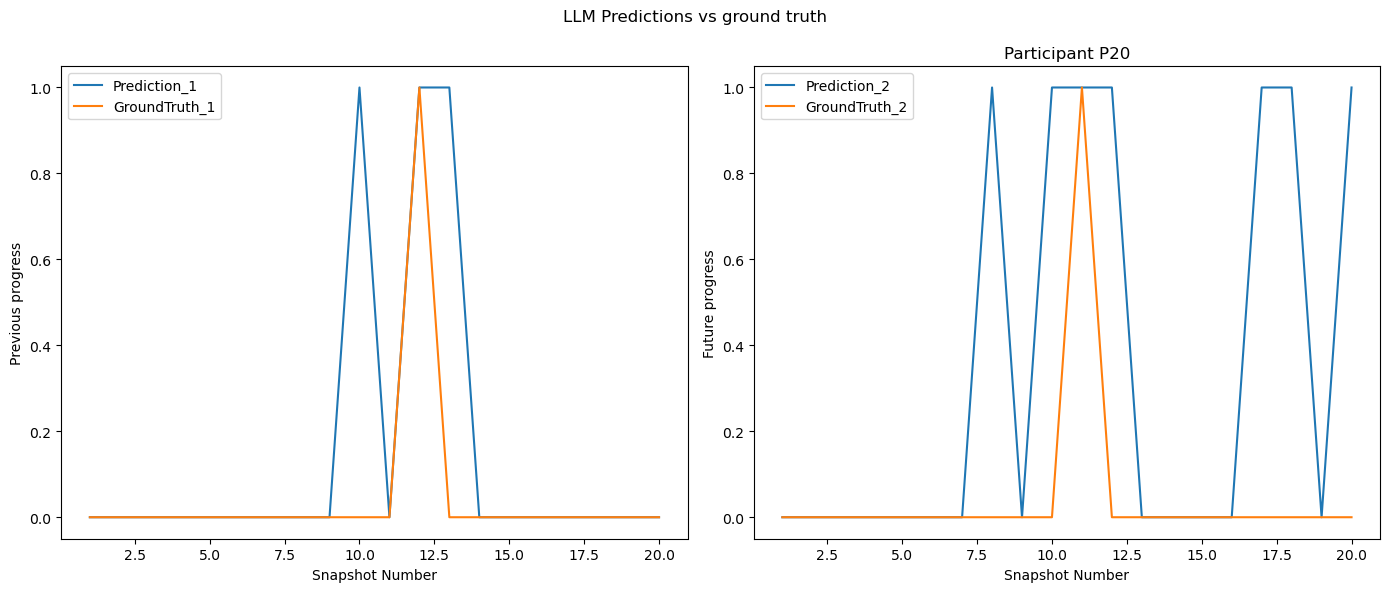

Participant P20:
Prediction_1: Accuracy = 0.9, F1 Score = 0.72
Prediction_2: Accuracy = 0.7, F1 Score = 0.53
GroundTruth_1
0.0    19
1.0     1
Name: count, dtype: int64
GroundTruth_2
0.0    19
1.0     1
Name: count, dtype: int64


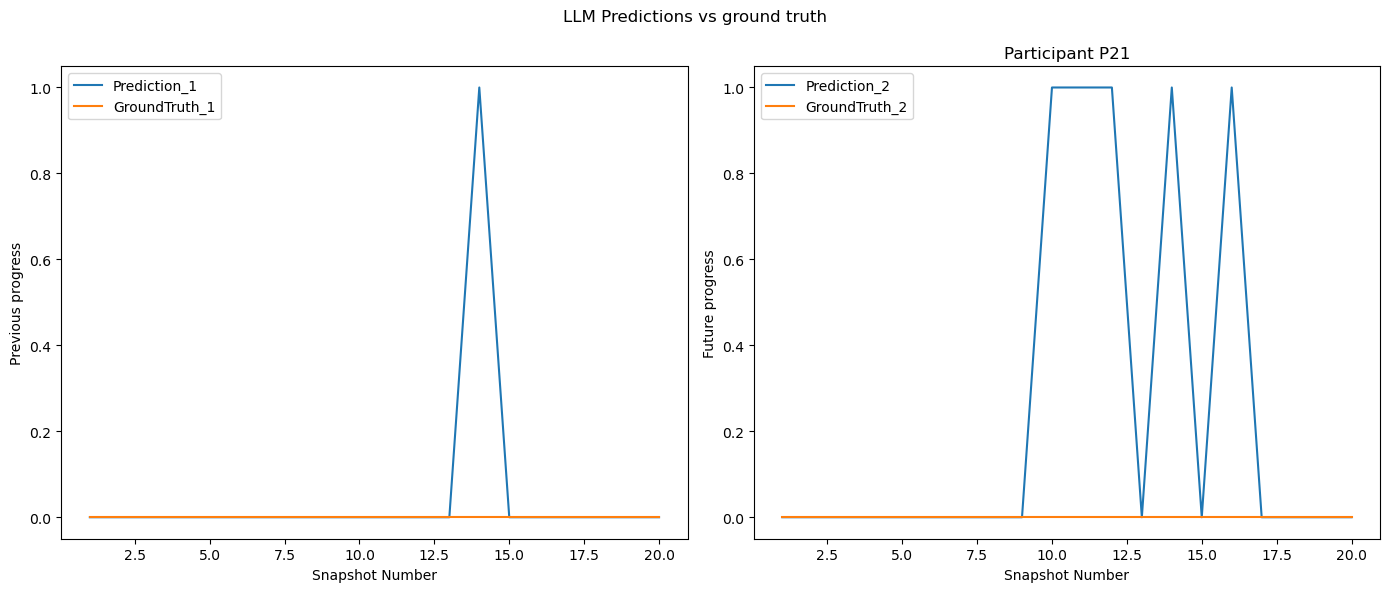

Participant P21:
Prediction_1: Accuracy = 0.95, F1 Score = 0.49
Prediction_2: Accuracy = 0.75, F1 Score = 0.43
GroundTruth_1
0.0    20
Name: count, dtype: int64
GroundTruth_2
0.0    20
Name: count, dtype: int64


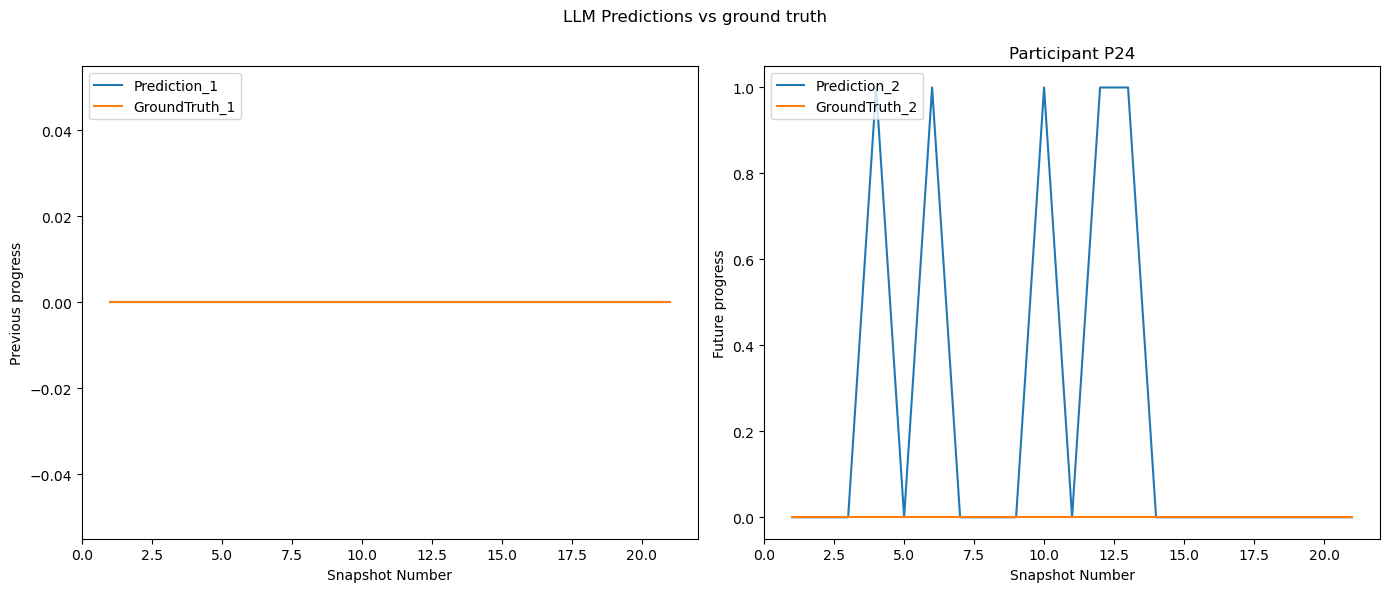

Participant P24:
Prediction_1: Accuracy = 1.0, F1 Score = 1.0
Prediction_2: Accuracy = 0.76, F1 Score = 0.43
GroundTruth_1
0.0    21
Name: count, dtype: int64
GroundTruth_2
0.0    21
Name: count, dtype: int64


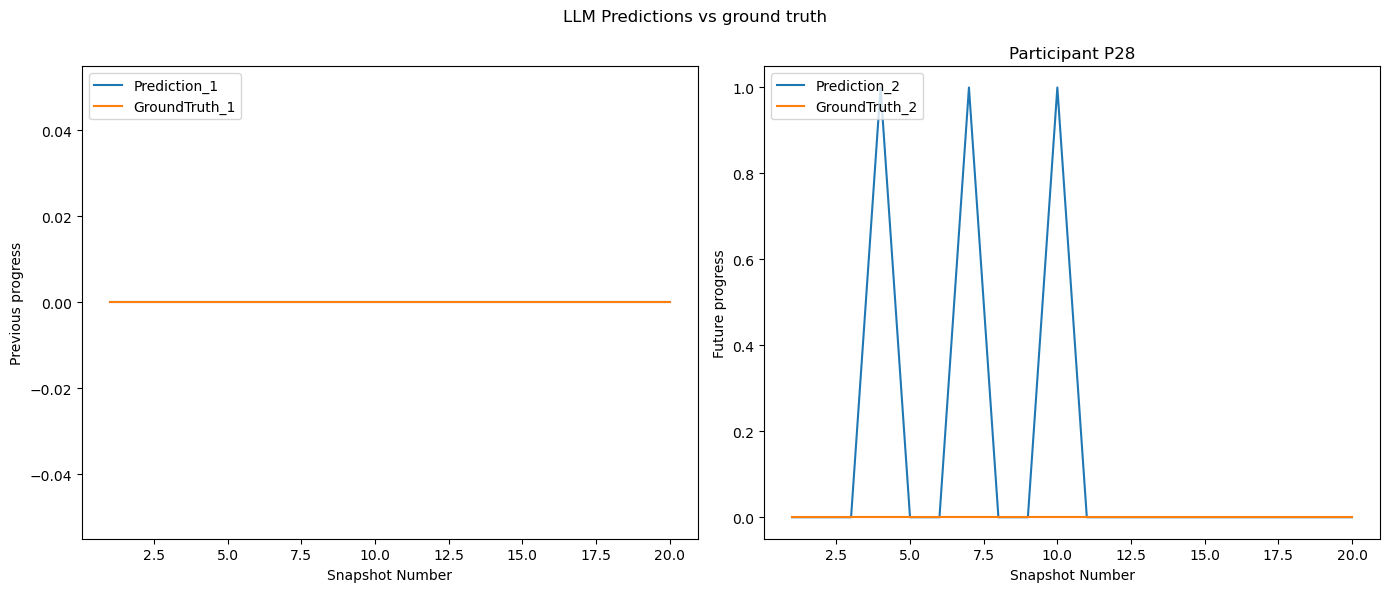

Participant P28:
Prediction_1: Accuracy = 1.0, F1 Score = 1.0
Prediction_2: Accuracy = 0.85, F1 Score = 0.46
GroundTruth_1
0.0    20
Name: count, dtype: int64
GroundTruth_2
0.0    20
Name: count, dtype: int64


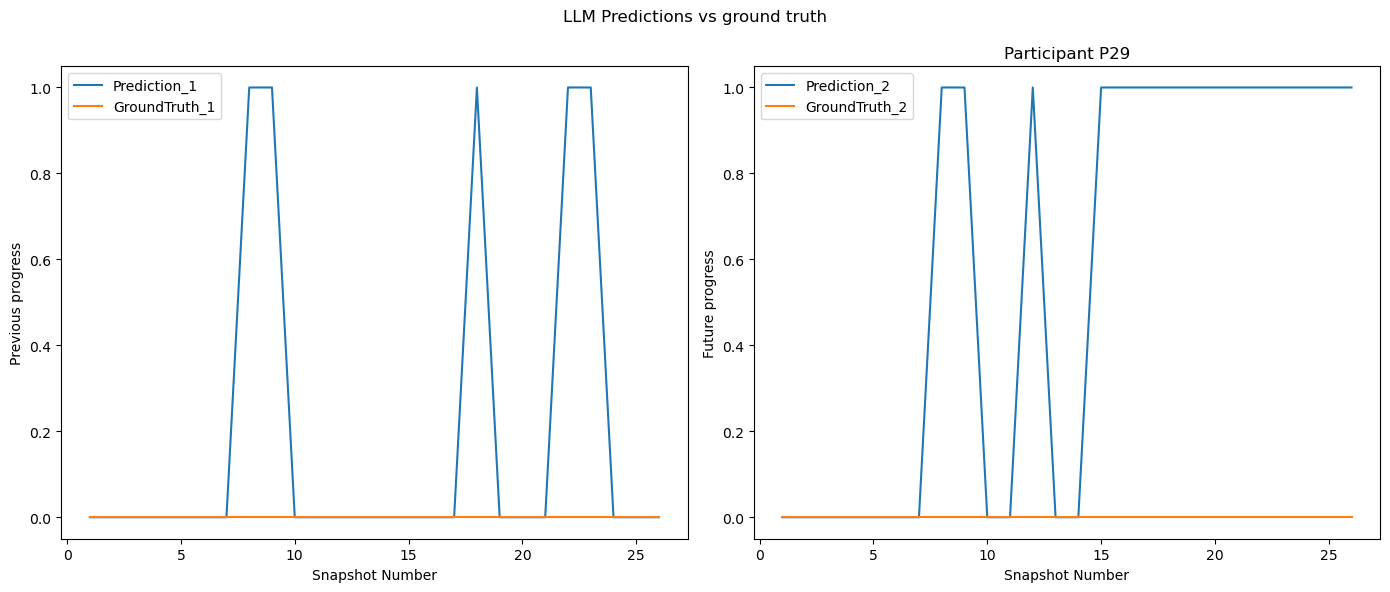

Participant P29:
Prediction_1: Accuracy = 0.81, F1 Score = 0.45
Prediction_2: Accuracy = 0.42, F1 Score = 0.3
GroundTruth_1
0.0    26
Name: count, dtype: int64
GroundTruth_2
0.0    26
Name: count, dtype: int64


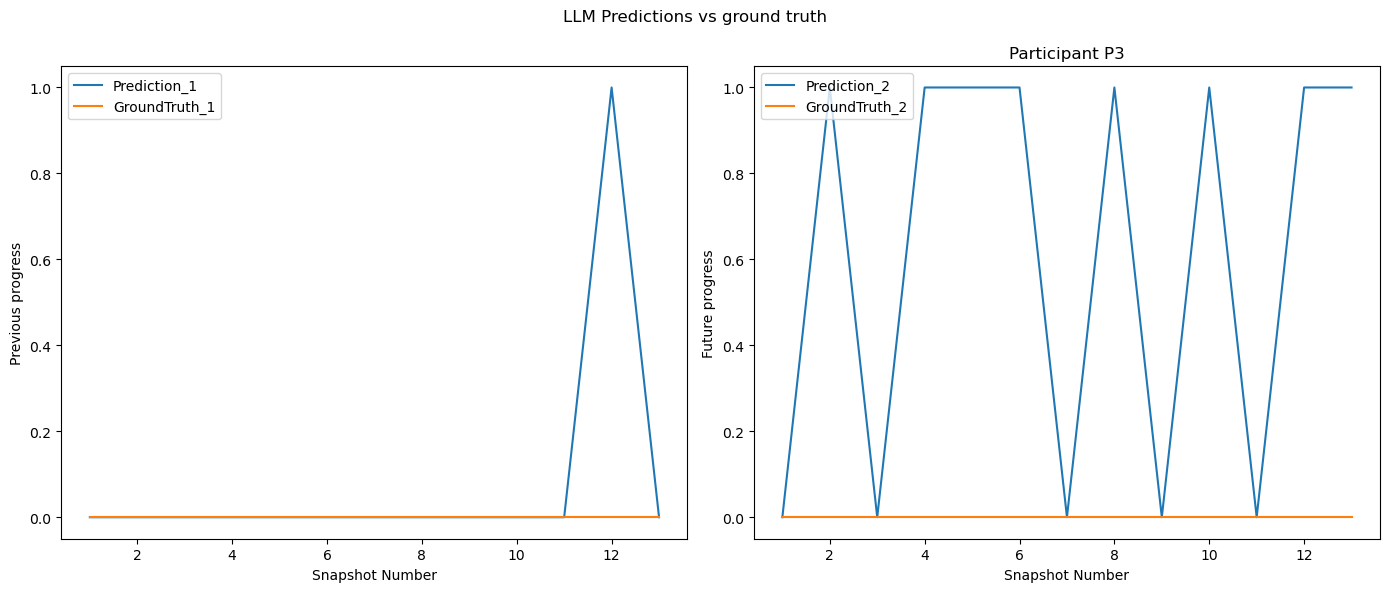

Participant P3:
Prediction_1: Accuracy = 0.86, F1 Score = 0.46
Prediction_2: Accuracy = 0.38, F1 Score = 0.28
GroundTruth_1
0.0    13
Name: count, dtype: int64
GroundTruth_2
0.0    13
Name: count, dtype: int64


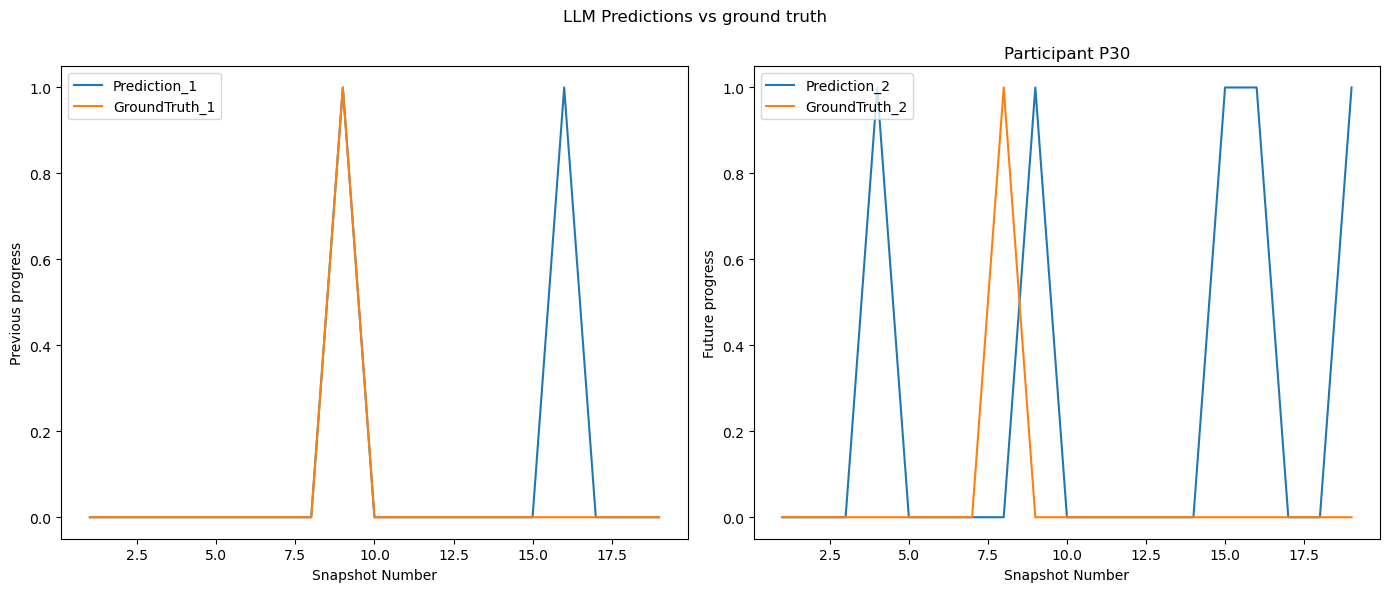

Participant P30:
Prediction_1: Accuracy = 0.95, F1 Score = 0.82
Prediction_2: Accuracy = 0.68, F1 Score = 0.41
GroundTruth_1
0.0    18
1.0     1
Name: count, dtype: int64
GroundTruth_2
0.0    18
1.0     1
Name: count, dtype: int64


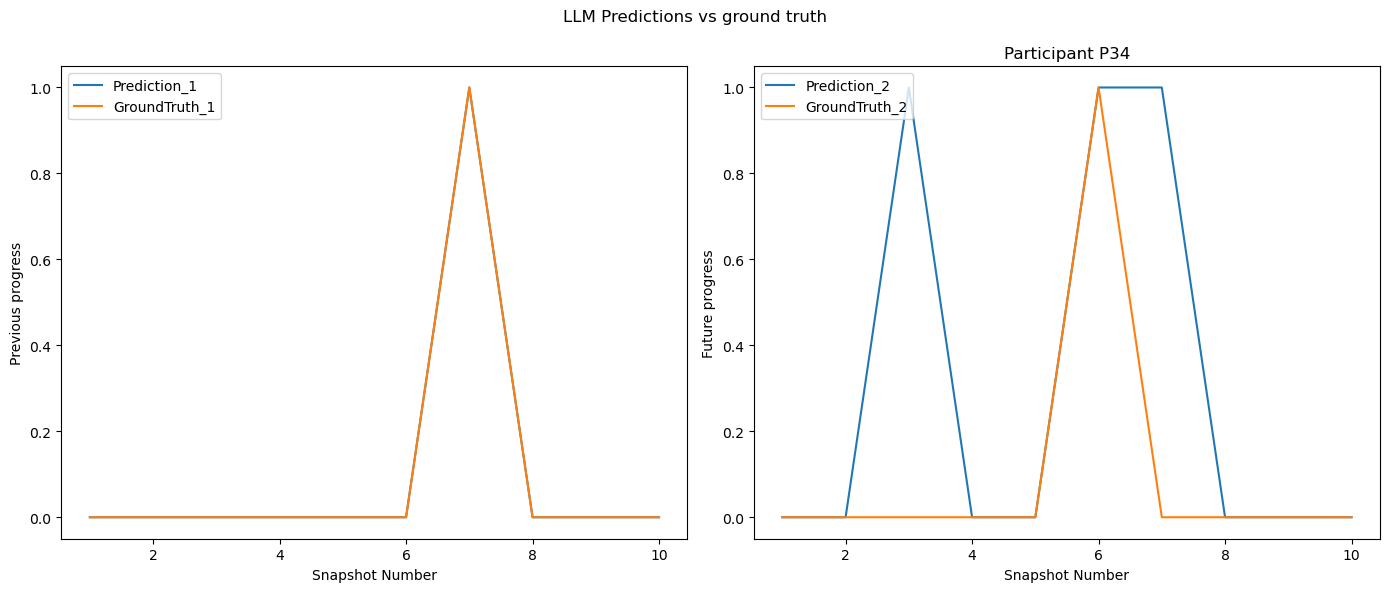

Participant P34:
Prediction_1: Accuracy = 1.0, F1 Score = 1.0
Prediction_2: Accuracy = 0.8, F1 Score = 0.69
GroundTruth_1
0.0    9
1.0    1
Name: count, dtype: int64
GroundTruth_2
0.0    9
1.0    1
Name: count, dtype: int64


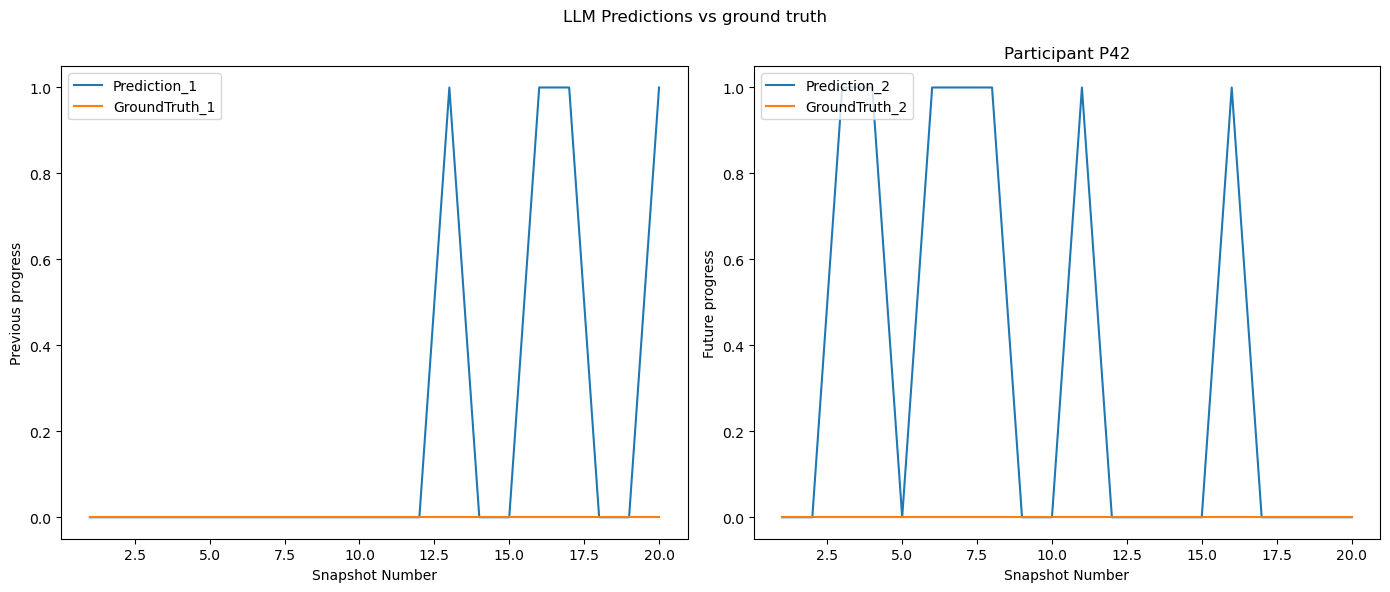

Participant P42:
Prediction_1: Accuracy = 0.81, F1 Score = 0.45
Prediction_2: Accuracy = 0.65, F1 Score = 0.39
GroundTruth_1
0.0    20
Name: count, dtype: int64
GroundTruth_2
0.0    20
Name: count, dtype: int64


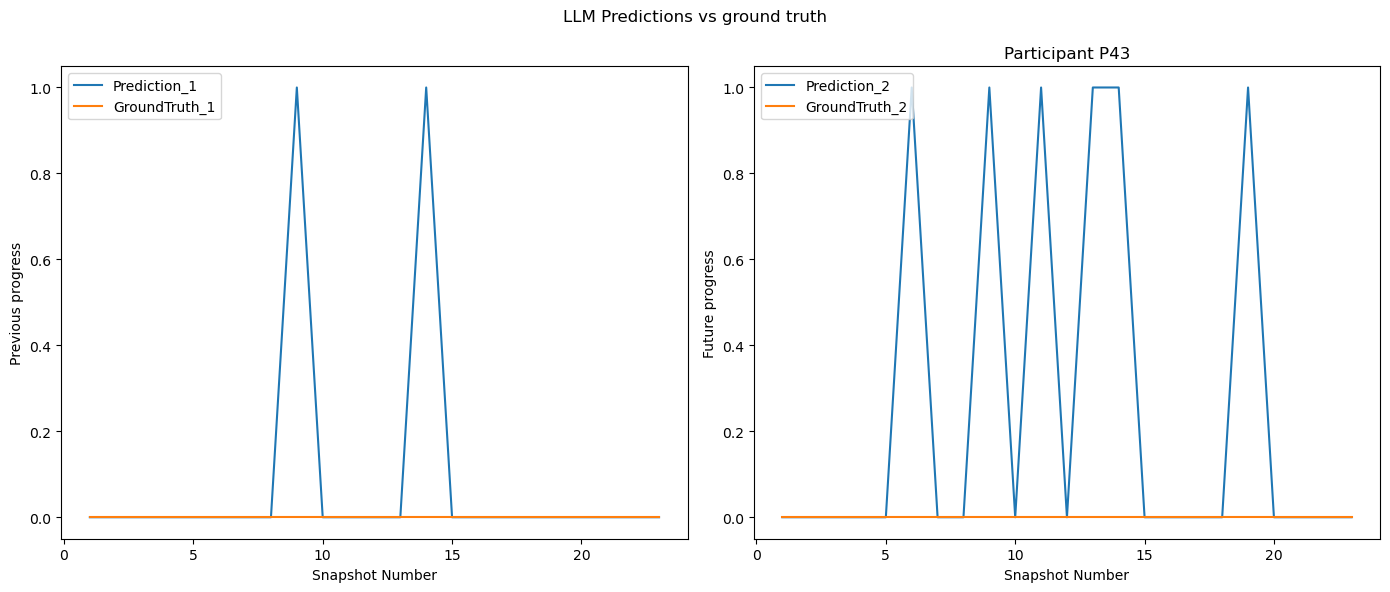

Participant P43:
Prediction_1: Accuracy = 0.92, F1 Score = 0.48
Prediction_2: Accuracy = 0.74, F1 Score = 0.42
GroundTruth_1
0.0    23
Name: count, dtype: int64
GroundTruth_2
0.0    23
Name: count, dtype: int64


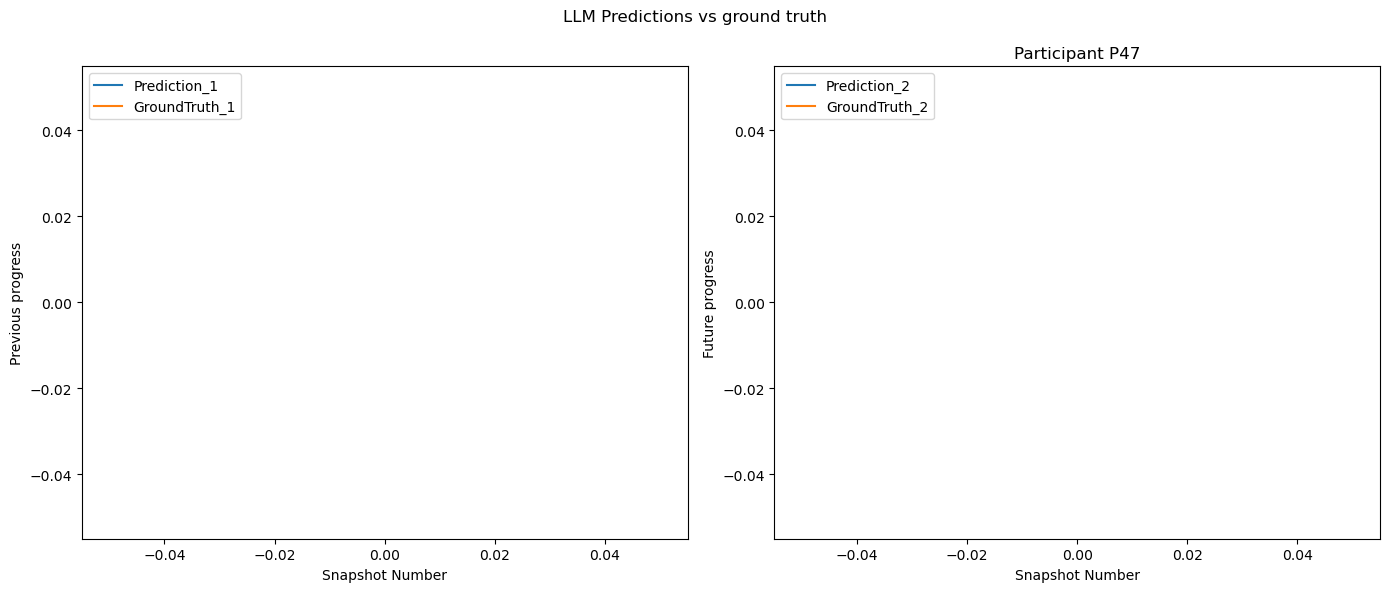

Participant P47:
Prediction_1: Accuracy = nan, F1 Score = nan
Prediction_2: Accuracy = nan, F1 Score = nan
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


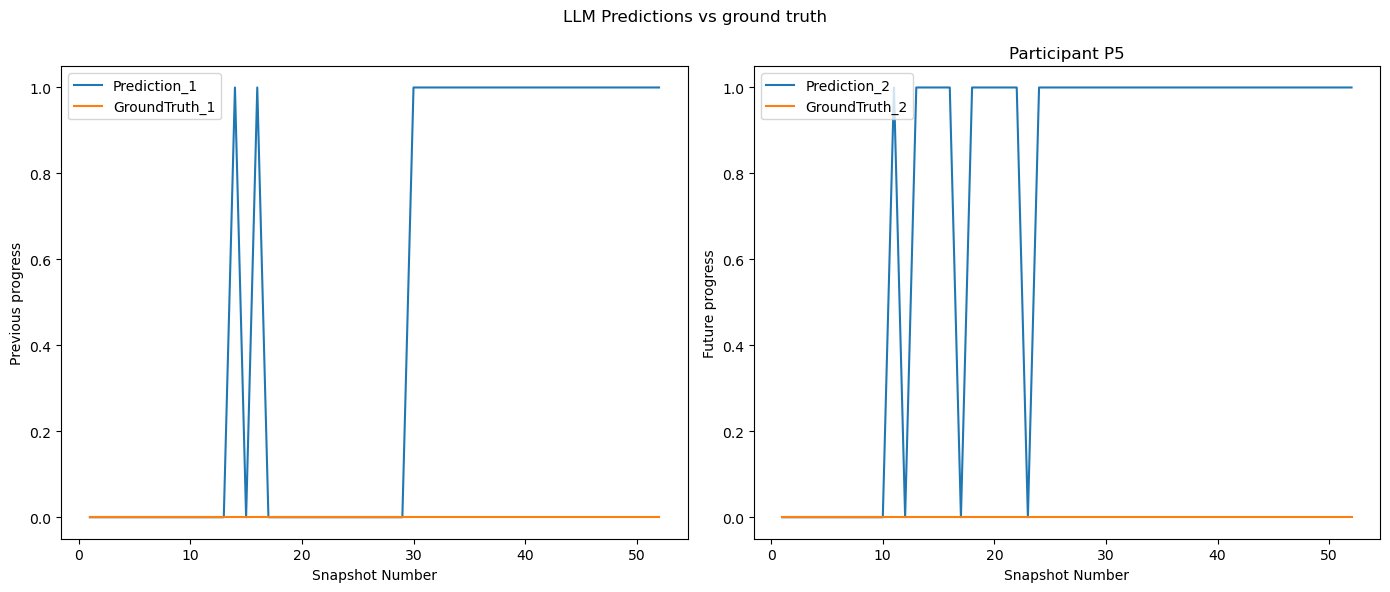

Participant P5:
Prediction_1: Accuracy = 0.51, F1 Score = 0.34
Prediction_2: Accuracy = 0.25, F1 Score = 0.2
GroundTruth_1
0.0    52
Name: count, dtype: int64
GroundTruth_2
0.0    52
Name: count, dtype: int64


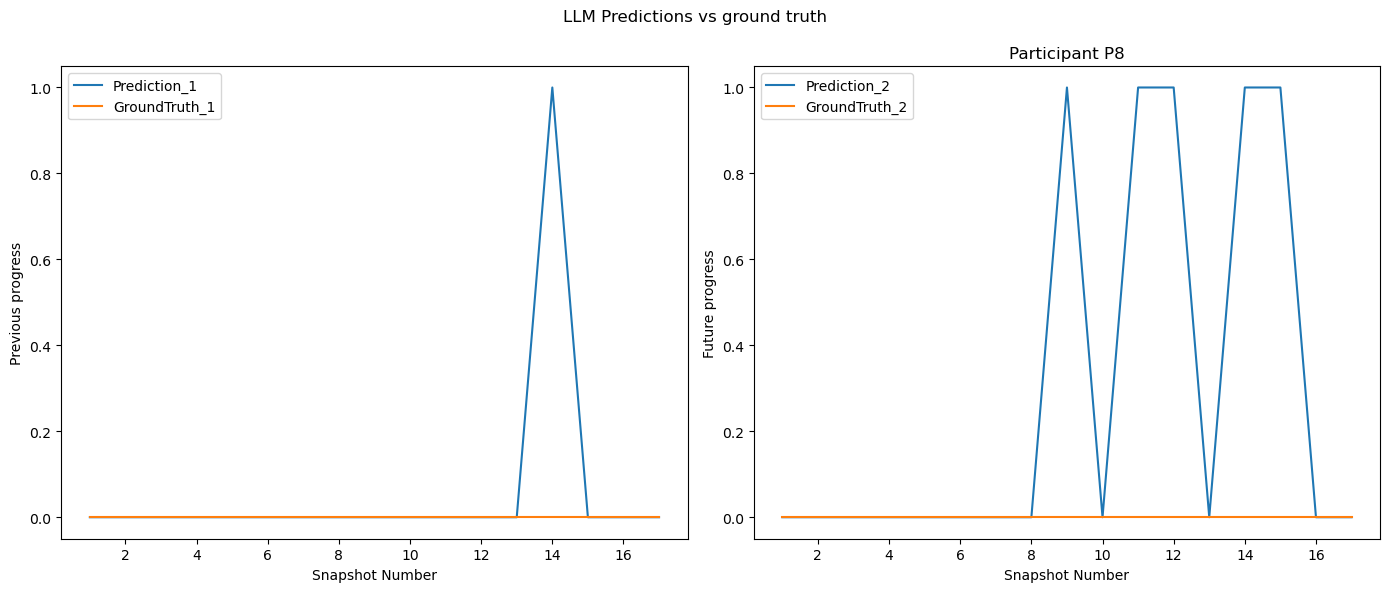

Participant P8:
Prediction_1: Accuracy = 0.94, F1 Score = 0.49
Prediction_2: Accuracy = 0.71, F1 Score = 0.41
GroundTruth_1
0.0    17
Name: count, dtype: int64
GroundTruth_2
0.0    17
Name: count, dtype: int64


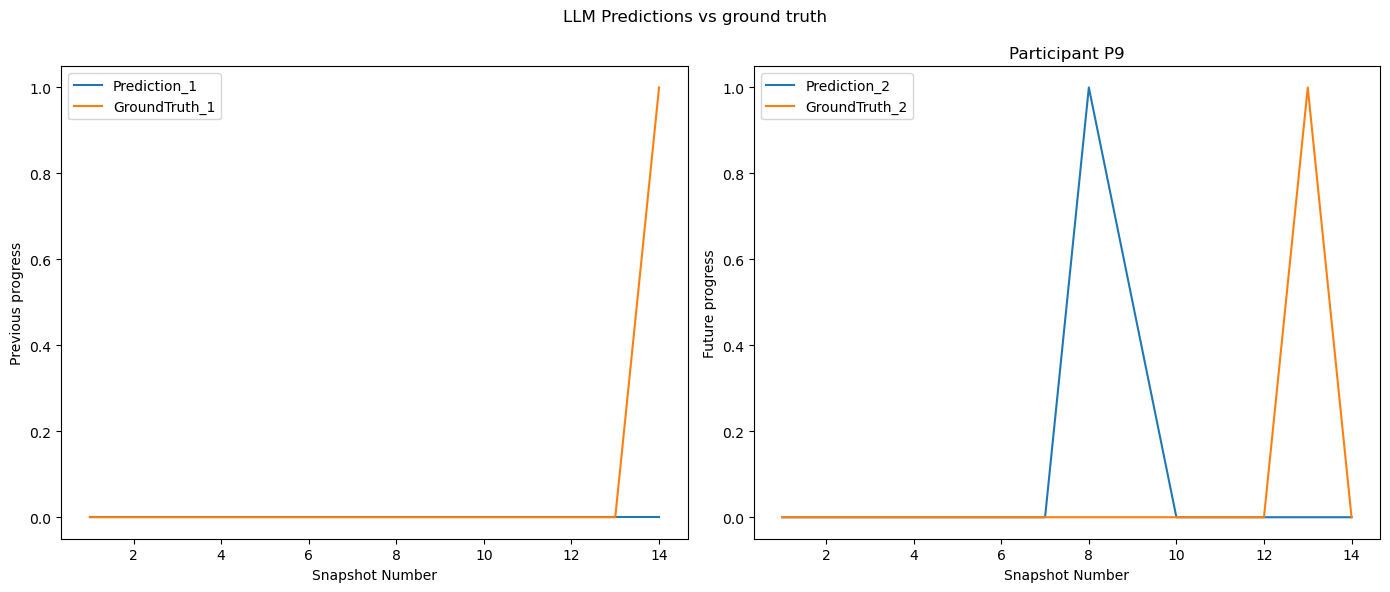

Participant P9:
Prediction_1: Accuracy = 0.93, F1 Score = 0.48
Prediction_2: Accuracy = 0.85, F1 Score = 0.46
GroundTruth_1
0.0    12
1.0     1
Name: count, dtype: int64
GroundTruth_2
0.0    12
1.0     1
Name: count, dtype: int64


In [115]:
plot_predictions(df_a3)

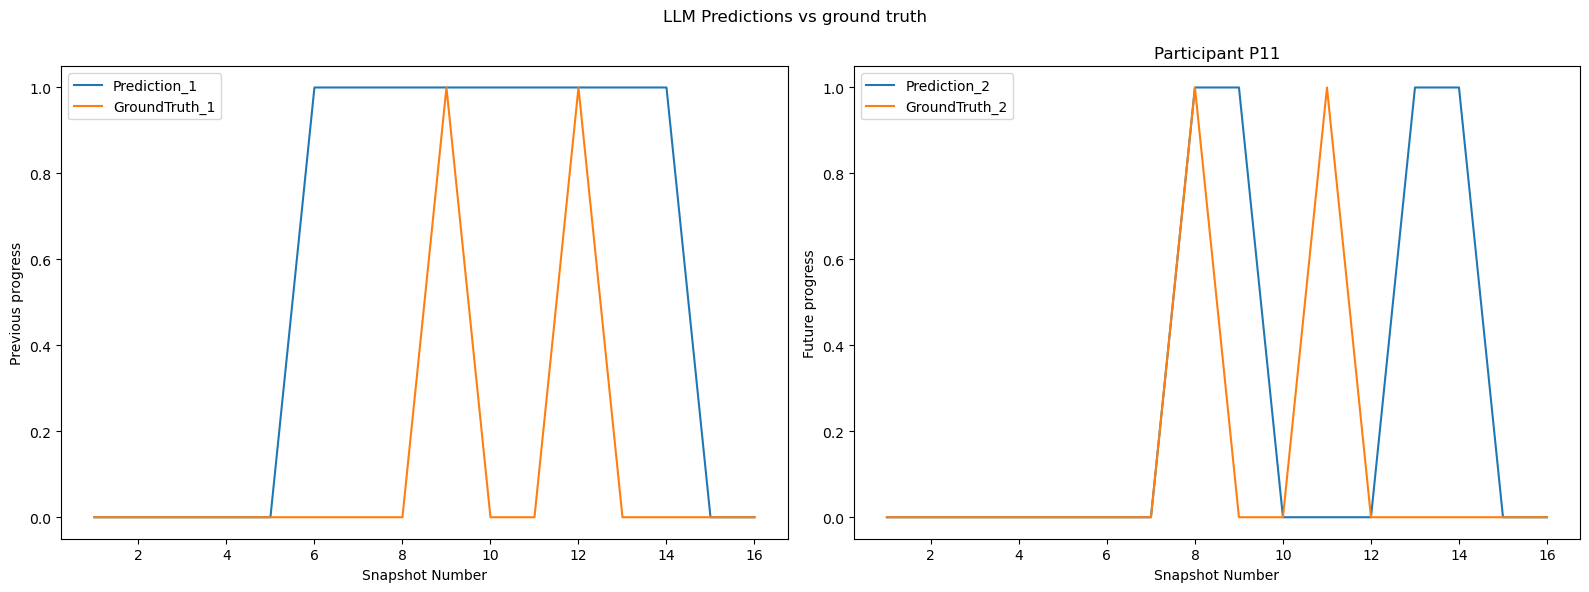

Participant P11:
Prediction_1: Accuracy = 0.59, F1 Score = 0.53
Prediction_2: Accuracy = 0.75, F1 Score = 0.59
GroundTruth_1
0.0    14
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    14
1.0     2
Name: count, dtype: int64


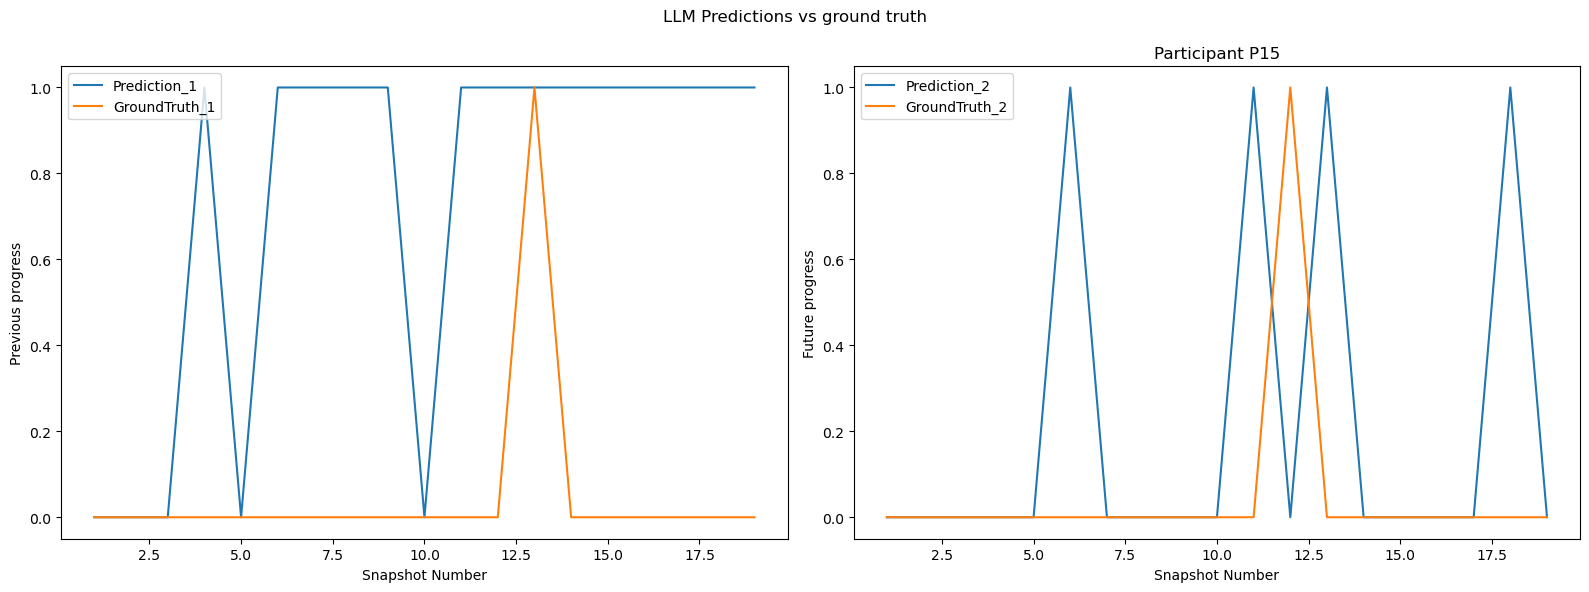

Participant P15:
Prediction_1: Accuracy = 0.3, F1 Score = 0.27
Prediction_2: Accuracy = 0.74, F1 Score = 0.42
GroundTruth_1
0.0    18
1.0     1
Name: count, dtype: int64
GroundTruth_2
0.0    18
1.0     1
Name: count, dtype: int64


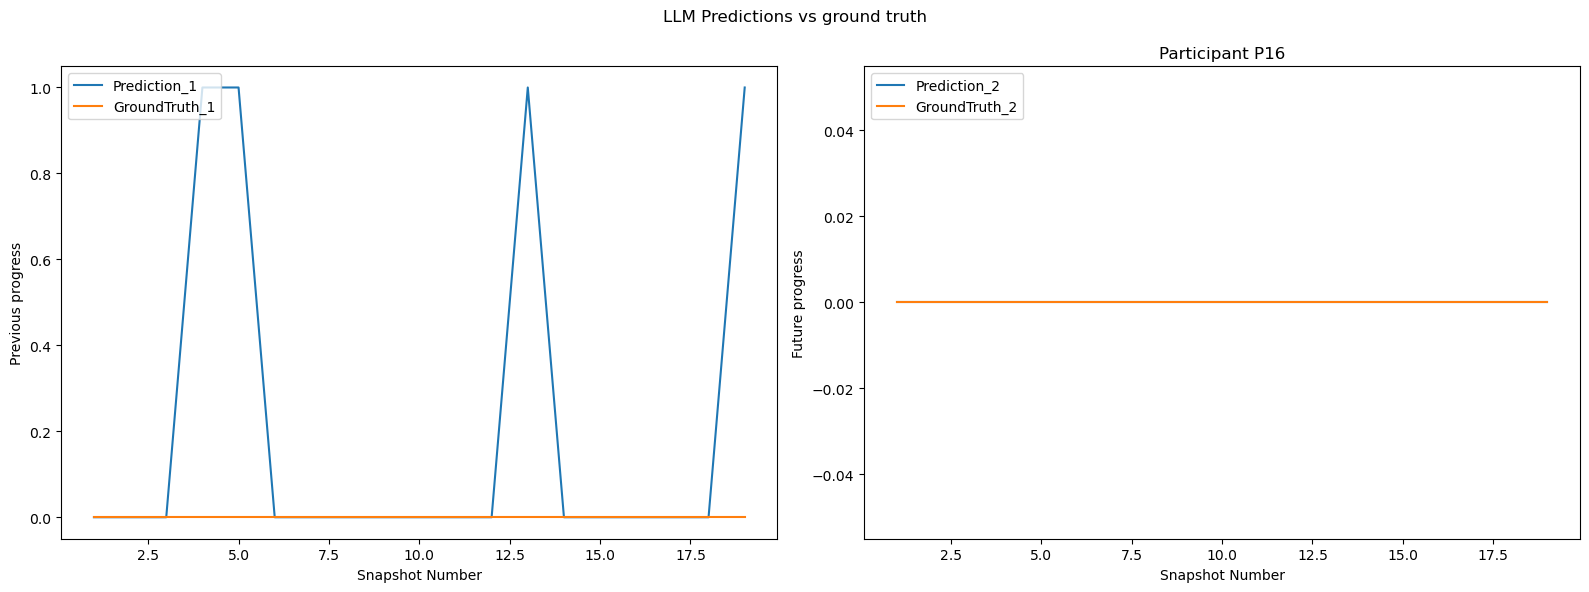

Participant P16:
Prediction_1: Accuracy = 0.8, F1 Score = 0.44
Prediction_2: Accuracy = 1.0, F1 Score = 1.0
GroundTruth_1
0.0    19
Name: count, dtype: int64
GroundTruth_2
0.0    19
Name: count, dtype: int64


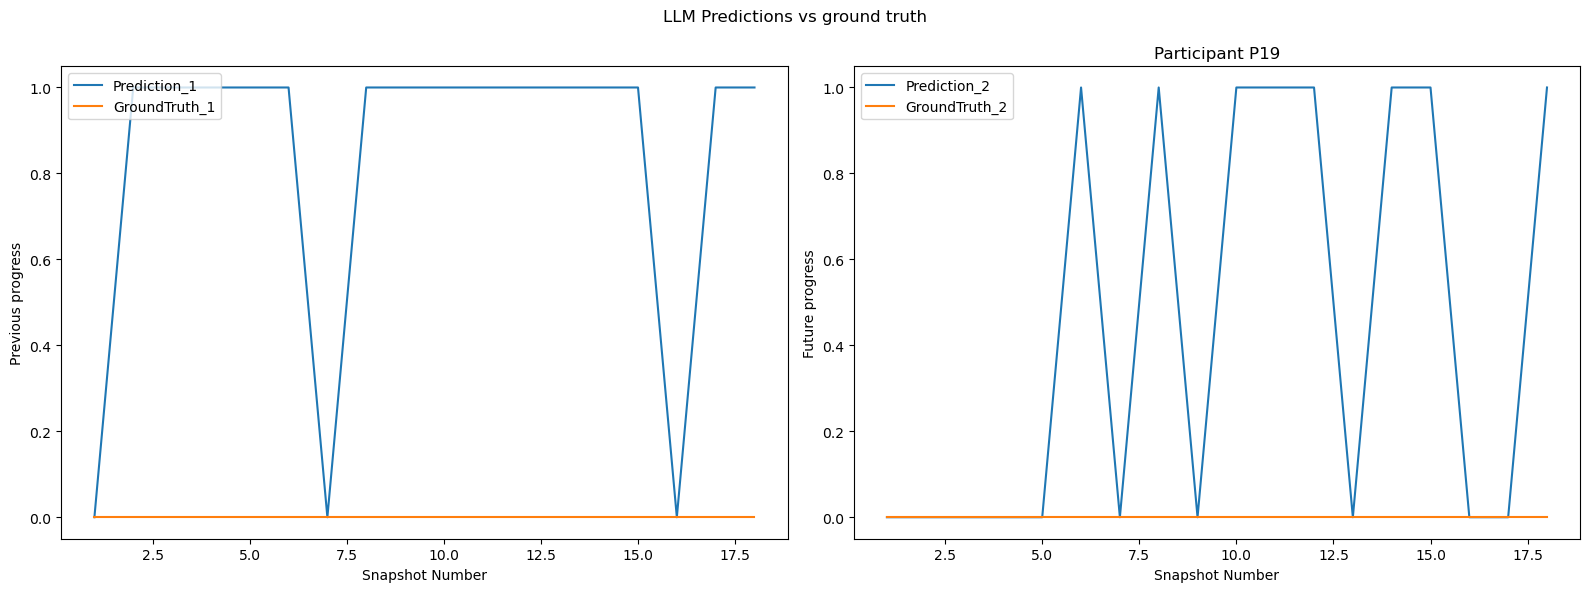

Participant P19:
Prediction_1: Accuracy = 0.16, F1 Score = 0.14
Prediction_2: Accuracy = 0.56, F1 Score = 0.36
GroundTruth_1
0.0    18
Name: count, dtype: int64
GroundTruth_2
0.0    18
Name: count, dtype: int64


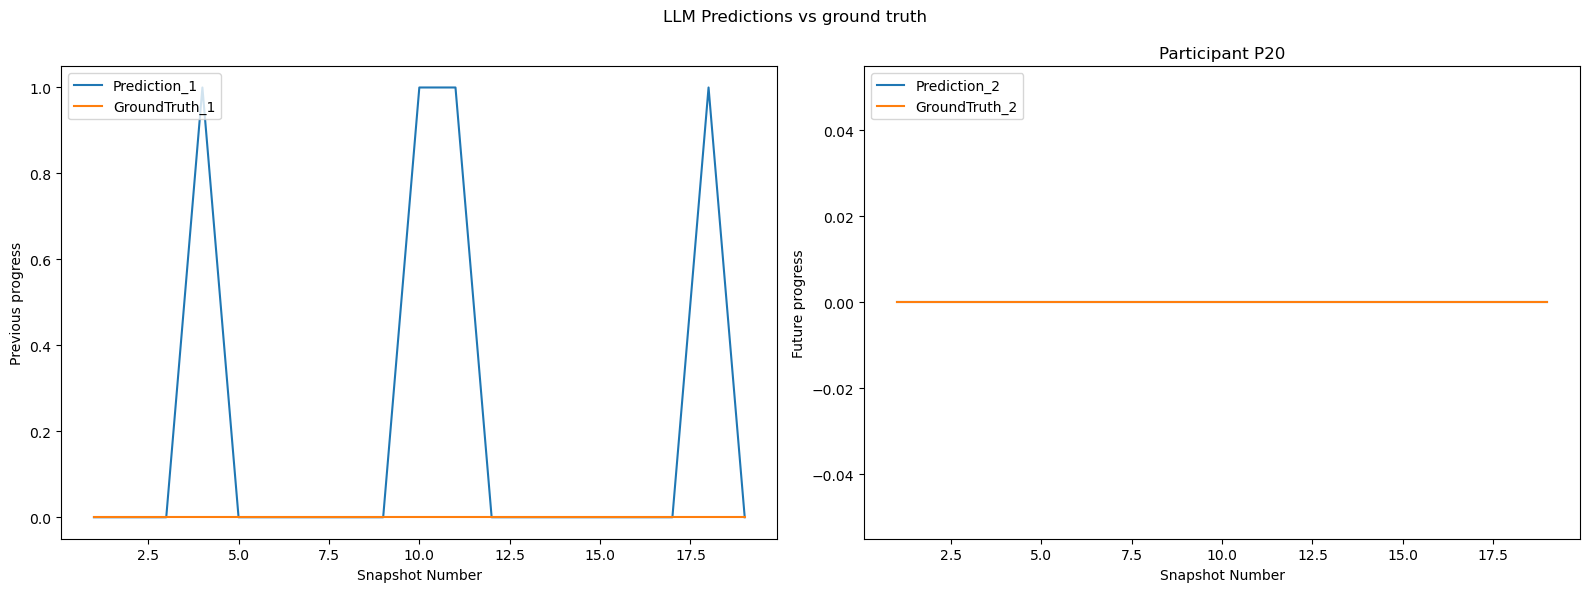

Participant P20:
Prediction_1: Accuracy = 0.8, F1 Score = 0.44
Prediction_2: Accuracy = 1.0, F1 Score = 1.0
GroundTruth_1
0.0    19
Name: count, dtype: int64
GroundTruth_2
0.0    19
Name: count, dtype: int64


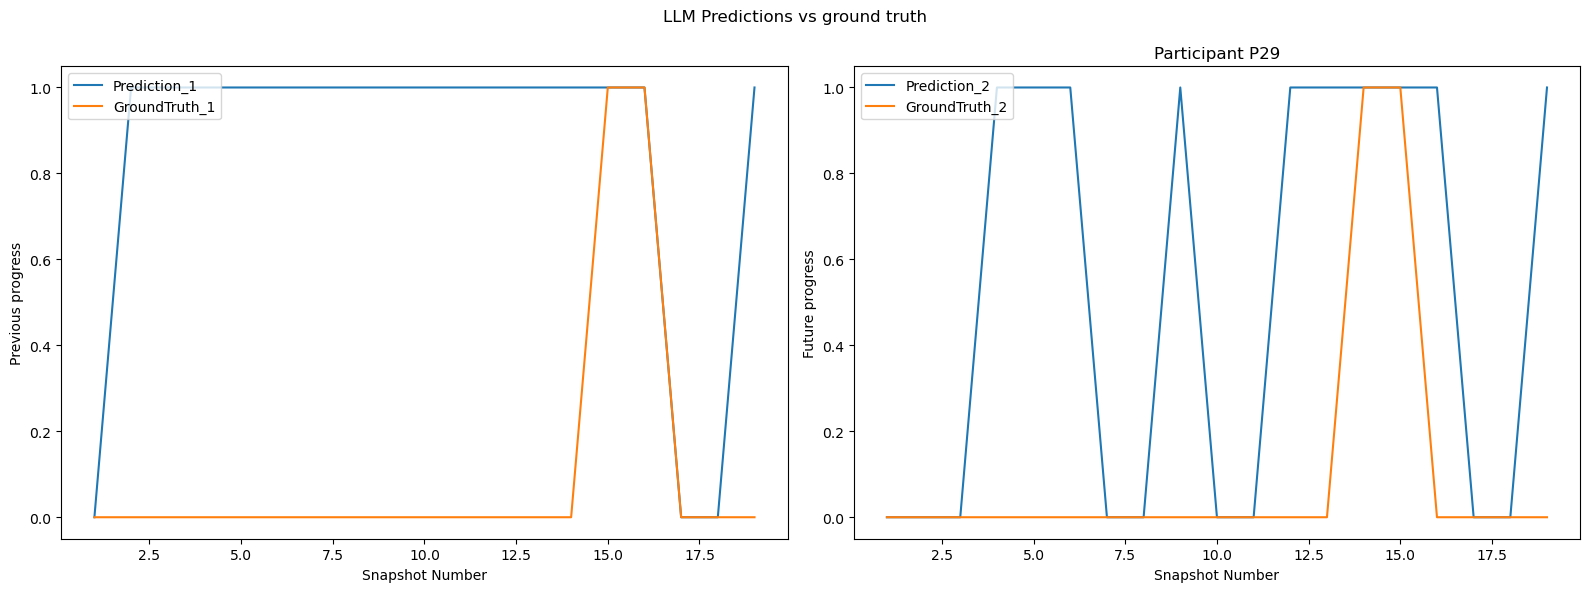

Participant P29:
Prediction_1: Accuracy = 0.25, F1 Score = 0.25
Prediction_2: Accuracy = 0.58, F1 Score = 0.51
GroundTruth_1
0.0    17
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    17
1.0     2
Name: count, dtype: int64


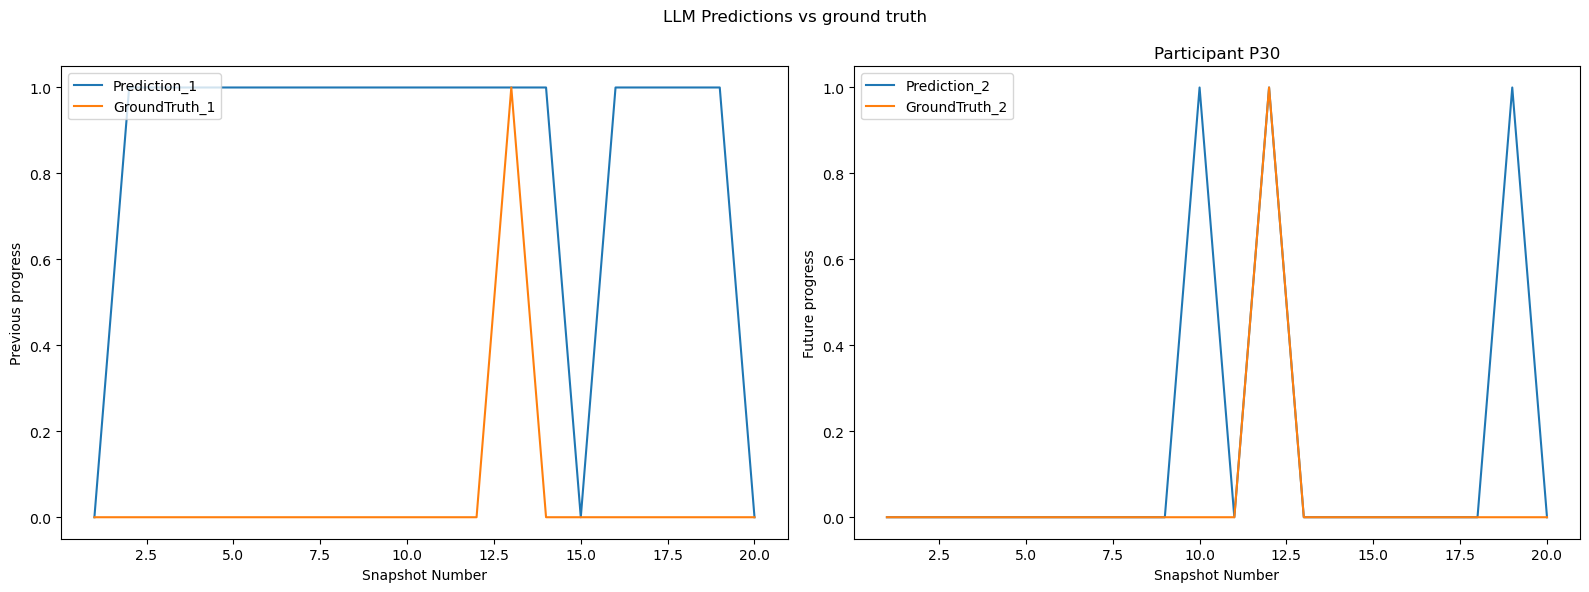

Participant P30:
Prediction_1: Accuracy = 0.24, F1 Score = 0.22
Prediction_2: Accuracy = 0.9, F1 Score = 0.72
GroundTruth_1
0.0    19
1.0     1
Name: count, dtype: int64
GroundTruth_2
0.0    19
1.0     1
Name: count, dtype: int64


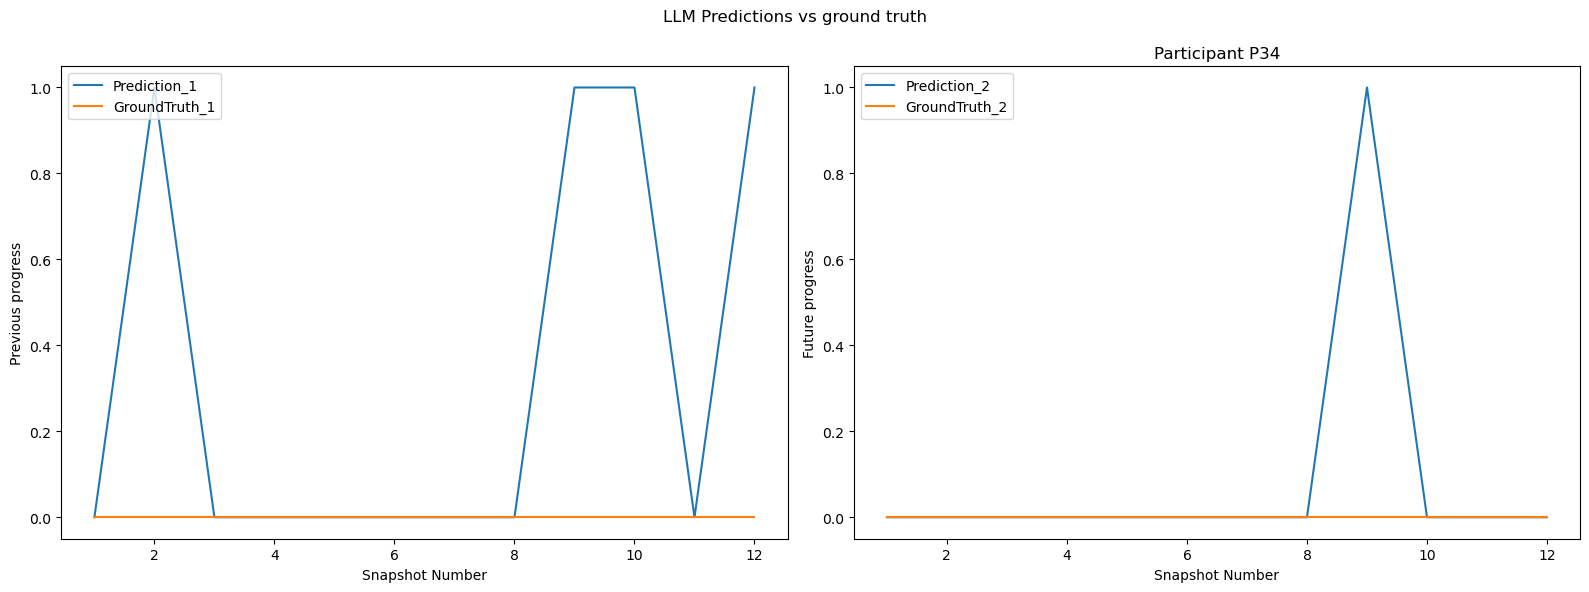

Participant P34:
Prediction_1: Accuracy = 0.69, F1 Score = 0.41
Prediction_2: Accuracy = 0.92, F1 Score = 0.48
GroundTruth_1
0.0    12
Name: count, dtype: int64
GroundTruth_2
0.0    12
Name: count, dtype: int64


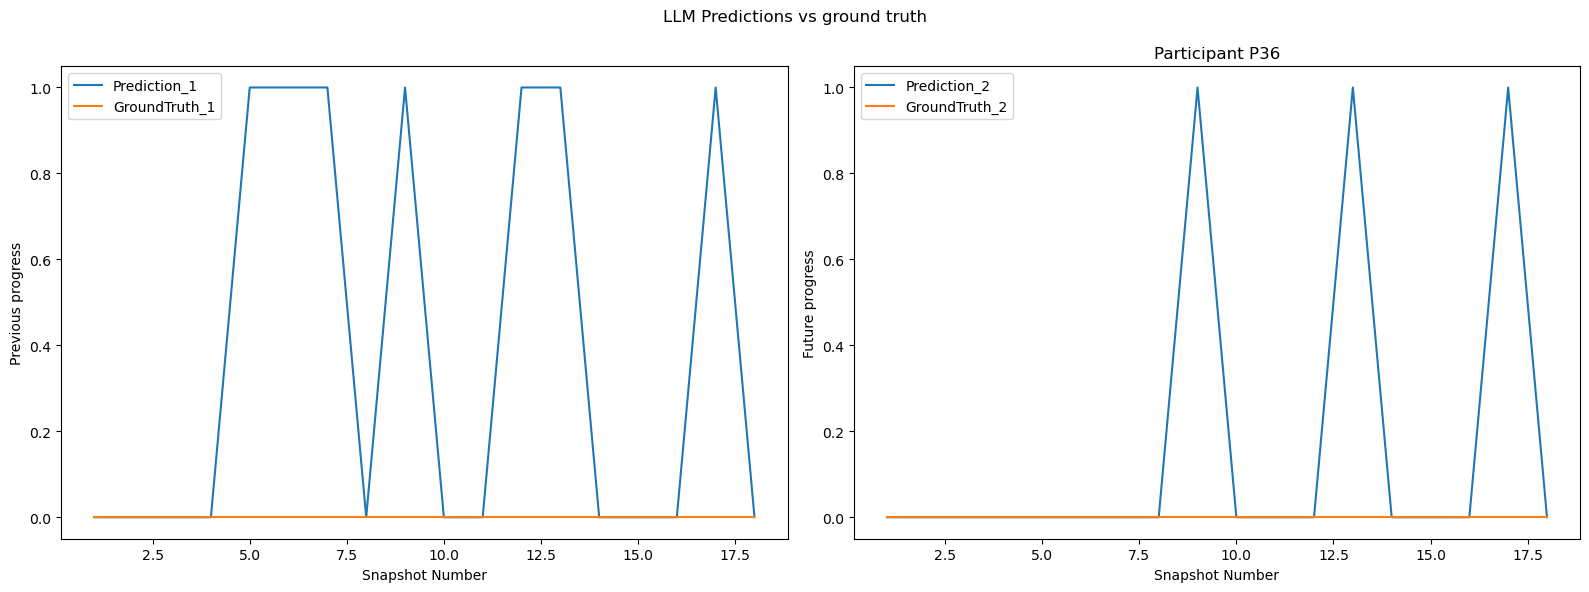

Participant P36:
Prediction_1: Accuracy = 0.63, F1 Score = 0.39
Prediction_2: Accuracy = 0.83, F1 Score = 0.45
GroundTruth_1
0.0    18
Name: count, dtype: int64
GroundTruth_2
0.0    18
Name: count, dtype: int64


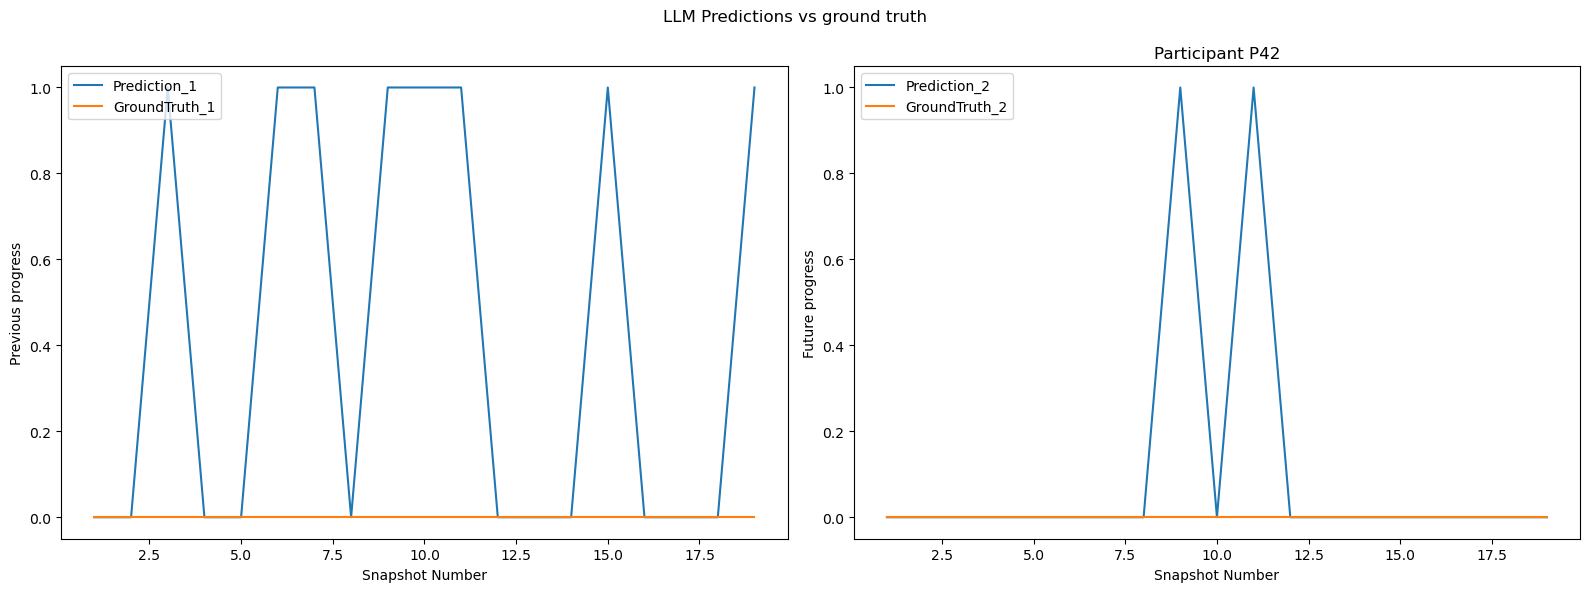

Participant P42:
Prediction_1: Accuracy = 0.55, F1 Score = 0.35
Prediction_2: Accuracy = 0.89, F1 Score = 0.47
GroundTruth_1
0.0    19
Name: count, dtype: int64
GroundTruth_2
0.0    19
Name: count, dtype: int64


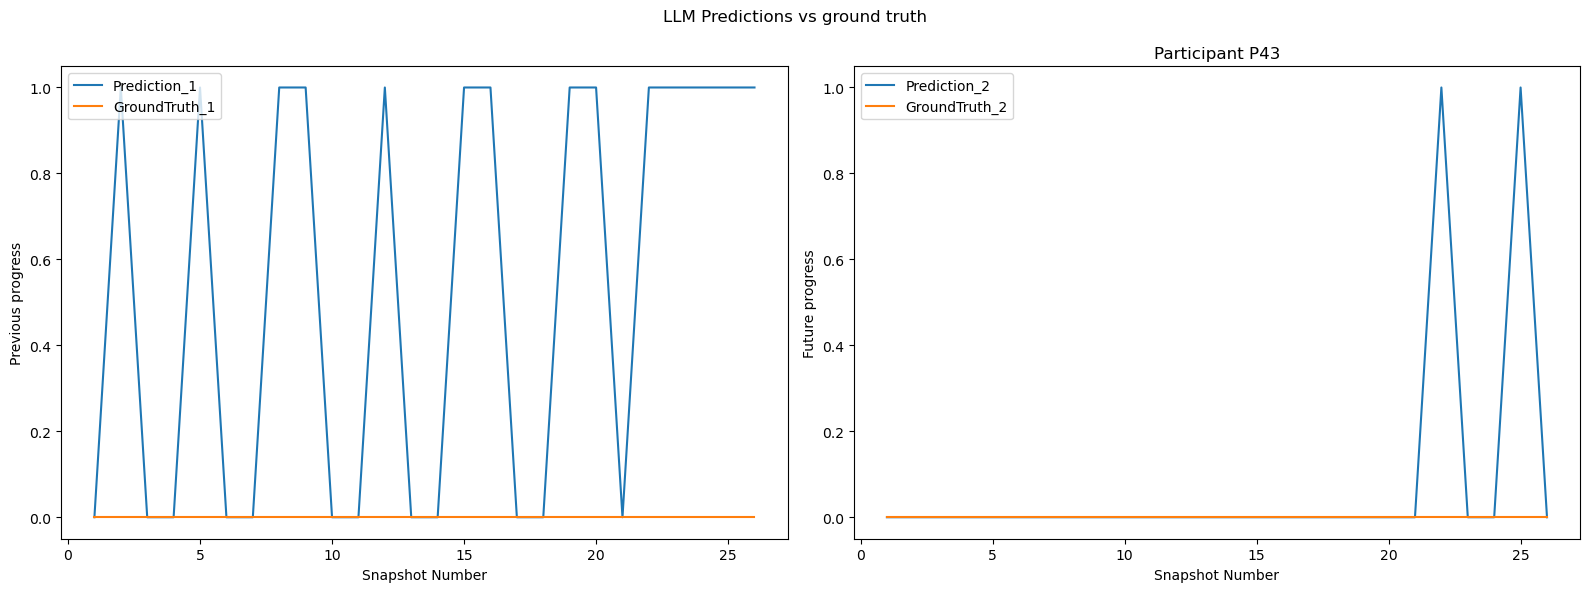

Participant P43:
Prediction_1: Accuracy = 0.44, F1 Score = 0.31
Prediction_2: Accuracy = 0.92, F1 Score = 0.48
GroundTruth_1
0.0    26
Name: count, dtype: int64
GroundTruth_2
0.0    26
Name: count, dtype: int64


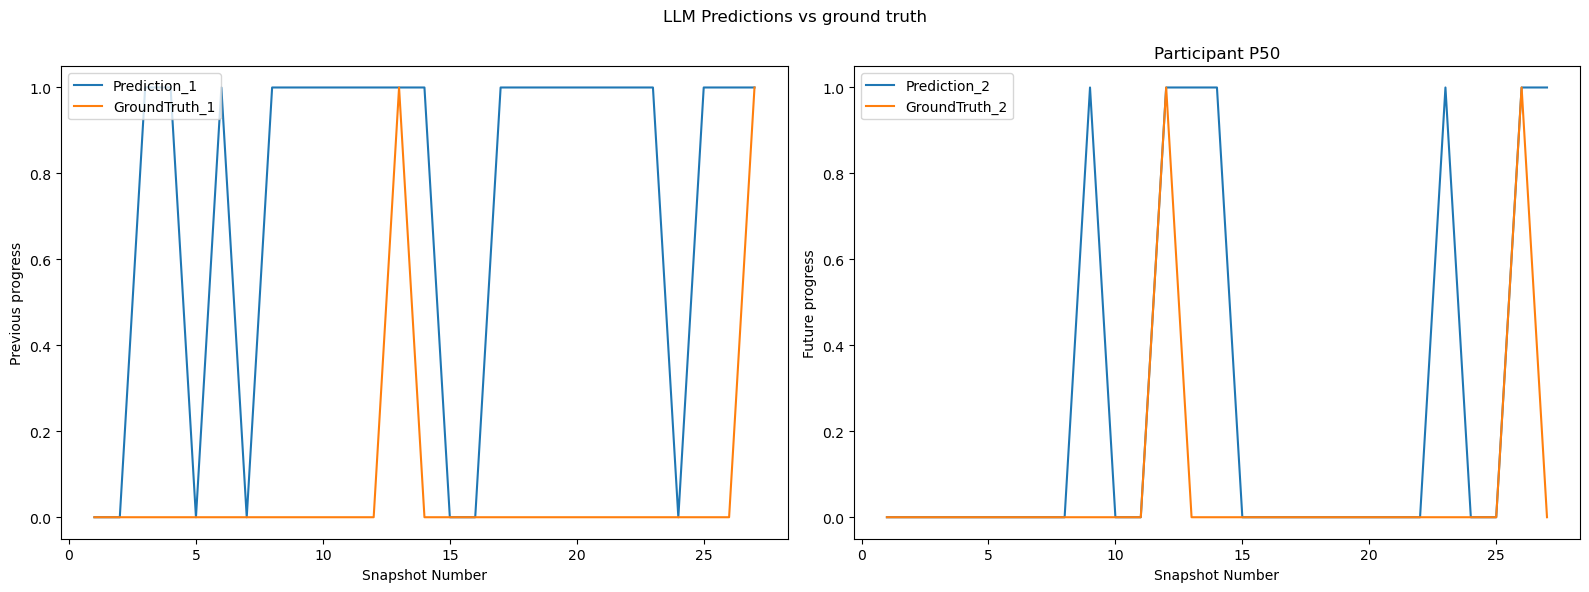

Participant P50:
Prediction_1: Accuracy = 0.32, F1 Score = 0.3
Prediction_2: Accuracy = 0.81, F1 Score = 0.67
GroundTruth_1
0.0    25
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    25
1.0     2
Name: count, dtype: int64


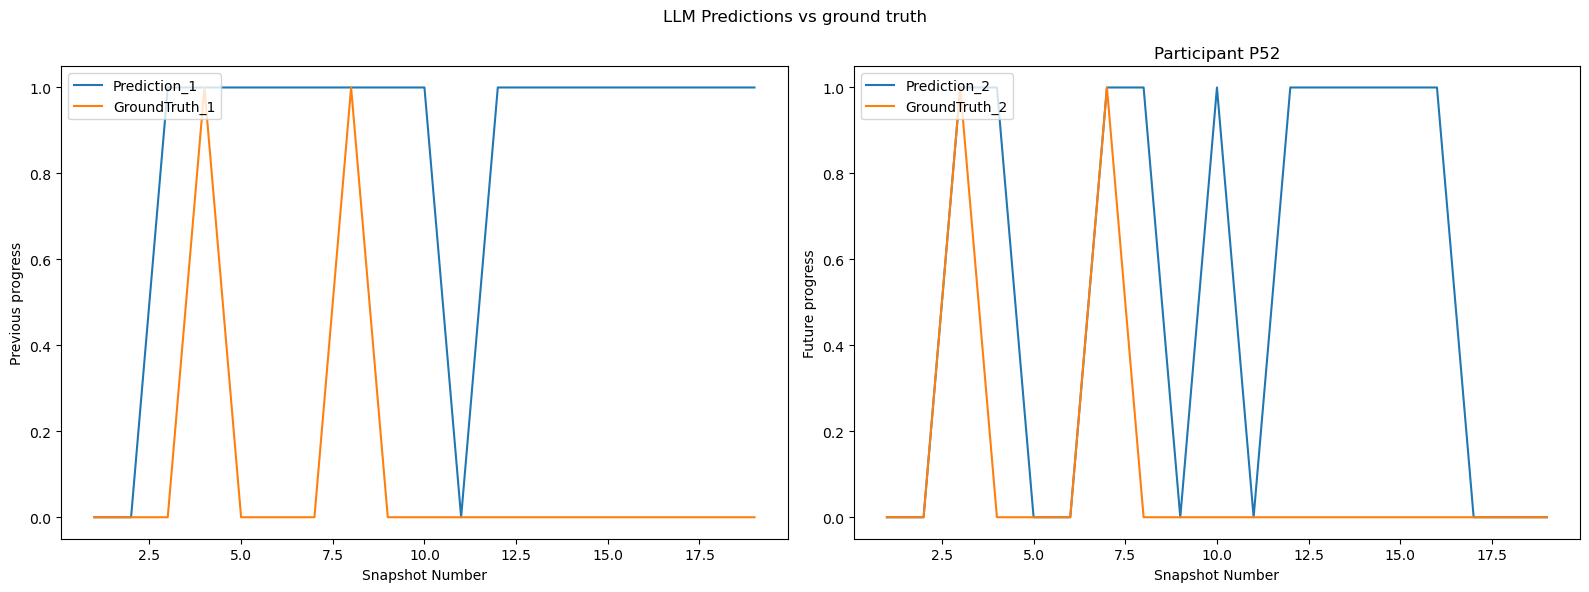

Participant P52:
Prediction_1: Accuracy = 0.25, F1 Score = 0.25
Prediction_2: Accuracy = 0.58, F1 Score = 0.51
GroundTruth_1
0.0    17
1.0     2
Name: count, dtype: int64
GroundTruth_2
0.0    17
1.0     2
Name: count, dtype: int64


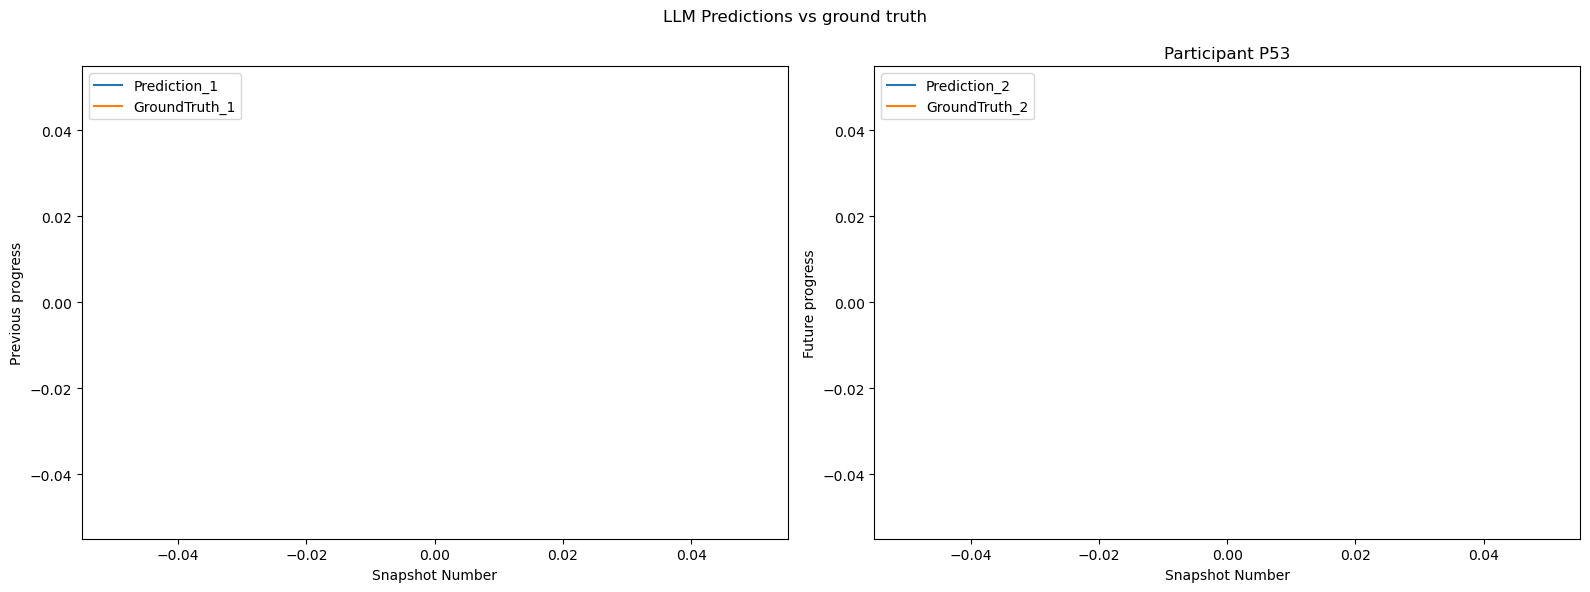

Participant P53:
Prediction_1: Accuracy = nan, F1 Score = nan
Prediction_2: Accuracy = nan, F1 Score = nan
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


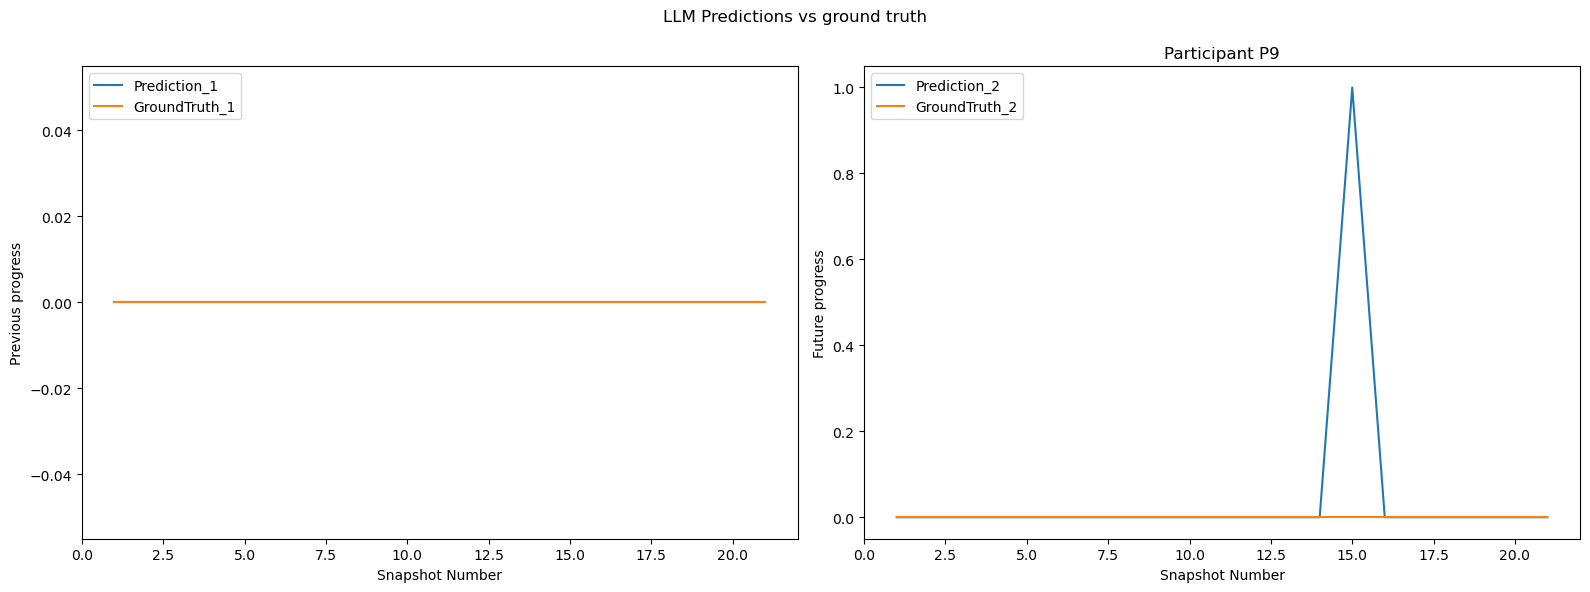

Participant P9:
Prediction_1: Accuracy = 1.0, F1 Score = 1.0
Prediction_2: Accuracy = 0.95, F1 Score = 0.49
GroundTruth_1
0.0    20
Name: count, dtype: int64
GroundTruth_2
0.0    20
Name: count, dtype: int64


In [104]:
plot_predictions(df_a4)